# Analysis of climate change impacts to global wine production (1995 to 2023)
UCB Project 1

## Team Members

- Theresa Fregoso
- Jeff Kim
- Brenda McCourt
- Madison Outland
- Rinal Shastri

## Hypothesis - There is a correlation between the weather and wine production
    - null hypothesis: there is no measureable correlation

## Research Questions
1. Which were the top wine producing countries in year 1995?
2. Which are the current top wine producing countries in year 2023?
3. What is the correlation between temperature and wine production?
4. What is the correlation between precipitation and wine production?
5. What is the optimal temperature for maximum production?
6. What is the optimal precipitation level for maximum wine production?
7. For which countries has the climate changed to favorably or unfavorably impact wine production?

This was made possible by the help of ChatGPT

## Data Sources
Wine Data:
- International Organization of Vine and Wine
  - [Statistics](https://www.oiv.int/what-we-do/statistics)
  - [Database Discovery Tool](https://www.oiv.int/what-we-do/data-discovery-report?oiv)
- ArcGIS Online
  - [Climate Change and Wine Regions](https://usgs.maps.arcgis.com/home/item.html?id=2cbf43f9c0dd45febf017fed3181d4fd)
Climate Data: 
- NOAA National Centers for Environmental Information
  - [Climate Data Online: Web Services Documentation](https://www.ncdc.noaa.gov/cdo-web/webservices/v2#gettingStarted)
  - [Data access](https://www.ncei.noaa.gov/access)
  - [NCEI Data Service API User Documentation](https://www.ncei.noaa.gov/support/access-data-service-api-user-documentation)

Python Libraries needed for running this code

In [1]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import numpy as np
from scipy import stats
import geopandas as gpd
import plotly.express as px
import nbformat
import ipywidgets as widgets
from IPython.display import display, clear_output
from shapely.geometry import Polygon, Point
from shapely.ops import unary_union
import matplotlib.patheffects as PathEffects
from matplotlib.patches import Polygon
from scipy.stats import linregress
import openpyxl
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm

## Organizing and cleaning data

Initial Loading of data

In [2]:
# Step 1: Load data from Excel file
file_path = r'Resources/Wine_Country_Weather_Data_adj.xlsx' 
wine_country_weather_data_df = pd.read_excel(file_path, sheet_name='Table')

# Step 2: Display the first few rows of the DataFrame to verify loading
wine_country_weather_data_df.head()

,Continent,Region/Country,Product,Variable,Year,Unit,Quantity,Country_Code,DP10,DP1X,...,DX90,EMNT,EMXP,EMXT,HTDD,MNPN,MXPN,PRCP,TAVG,TMAX
0,Asia,Afghanistan,Wine,Consumption,1995,1000 hl,0,AF,0,0,...,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
1,Asia,Afghanistan,Wine,Imports,1995,1000 hl,0,AF,0,0,...,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
2,Asia,Afghanistan,Wine,Production,1995,1000 hl,0,AF,0,0,...,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
3,Asia,Afghanistan,Wine,Consumption,1996,1000 hl,0,AF,0,0,...,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
4,Asia,Afghanistan,Wine,Imports,1996,1000 hl,0,AF,0,0,...,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0


In [3]:
# Load Climate Variable Definitions from Excel file
file_path = r'Resources/Wine_Country_Weather_Data_adj.xlsx' 
glossary_df = pd.read_excel(file_path, sheet_name='Glossary')

# Adjust display options to show entire strings
pd.set_option('display.max_colwidth', 60)

# Display the first few rows of the glossary dataframe
glossary_df

,DataType,Definition
0,DP10,Number of days with >= 0.1 inch
1,DP1X,Number of days with >= 1.00 inch
2,DT32,Number of days with maximum temperature <= 32 degrees Fa...
3,DX70,Number of days with maximum temperature >= 70 degrees Fa...
4,DX90,Number of days with maximum temperature >= 90 degrees Fa...
5,EMNT,Extreme minimum temperature for month. Lowest daily mini...
6,EMXP,Highest daily total of precipitation in the month. Given...
7,EMXT,Extreme maximum temperature for month. Highest daily max...
8,HTDD,Heating Degree Days. Computed when daily average tempera...
9,MNPN,Monthly Mean Minimum Temperature of evaporation pan wate...


Convert quantity from 1000hl to gallons  
Assuming the quantity column is named 'quantity' and it is in '1000hl'  
1 hectoliter (hl) is approximately 26.4172 gallons  
Therefore, 1000 hl is 1000 * 26.4172 gallons  

In [4]:
conversion_factor = 26.4172
wine_country_weather_data_df['Quantity_gallons'] = wine_country_weather_data_df['Quantity'].astype(float) * 1000 * conversion_factor

# Reorder columns to place 'Gallons' right after 'Quantity'
columns = list(wine_country_weather_data_df.columns)
quantity_index = columns.index('Quantity')
columns.insert(quantity_index + 1, columns.pop(columns.index('Quantity_gallons')))
wine_country_weather_data_final_df = wine_country_weather_data_df[columns]

# Remove blank records where country_Country_Country_code is blank
wine_country_weather_data_final_df = wine_country_weather_data_final_df[wine_country_weather_data_final_df['Country_Code'].notna()].reset_index(drop=True)


# Display the modified dataframe
# print(wine_country_weather_data_final_df.head())
wine_country_weather_data_final_df.head()

,Continent,Region/Country,Product,Variable,Year,Unit,Quantity,Quantity_gallons,Country_Code,DP10,...,DX90,EMNT,EMXP,EMXT,HTDD,MNPN,MXPN,PRCP,TAVG,TMAX
0,Asia,Afghanistan,Wine,Consumption,1995,1000 hl,0,0.0,AF,0,...,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
1,Asia,Afghanistan,Wine,Imports,1995,1000 hl,0,0.0,AF,0,...,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
2,Asia,Afghanistan,Wine,Production,1995,1000 hl,0,0.0,AF,0,...,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
3,Asia,Afghanistan,Wine,Consumption,1996,1000 hl,0,0.0,AF,0,...,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
4,Asia,Afghanistan,Wine,Imports,1996,1000 hl,0,0.0,AF,0,...,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0


Prepare data for climate analysis

In [5]:
#Load wine data
# Filter the data to include only wine production records
wine_production_df = wine_country_weather_data_final_df[(wine_country_weather_data_final_df['Variable'] == 'Production')]

# Group by Region/Country and sum the Quantity_gallons
wine_production_by_region = wine_production_df.groupby('Region/Country')['Quantity_gallons'].sum().reset_index()

# Convert the Quantity_gallons to millions
wine_production_by_region['Quantity_gallons_million'] = wine_production_by_region['Quantity_gallons'] / 1e6

wine_production_df

,Continent,Region/Country,Product,Variable,Year,Unit,Quantity,Quantity_gallons,Country_Code,DP10,...,DX90,EMNT,EMXP,EMXT,HTDD,MNPN,MXPN,PRCP,TAVG,TMAX
2,Asia,Afghanistan,Wine,Production,1995,1000 hl,0,0.0,AF,0,...,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
5,Asia,Afghanistan,Wine,Production,1996,1000 hl,0,0.0,AF,0,...,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
8,Asia,Afghanistan,Wine,Production,1997,1000 hl,0,0.0,AF,0,...,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
11,Asia,Afghanistan,Wine,Production,1998,1000 hl,0,0.0,AF,0,...,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
14,Asia,Afghanistan,Wine,Production,1999,1000 hl,0,0.0,AF,0,...,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19045,Africa,Zimbabwe,Wine,Production,2018,1000 hl,20,528344.0,ZI,0,...,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
19049,Africa,Zimbabwe,Wine,Production,2019,1000 hl,14,369840.8,ZI,0,...,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
19053,Africa,Zimbabwe,Wine,Production,2020,1000 hl,14,369840.8,ZI,0,...,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0
19057,Africa,Zimbabwe,Wine,Production,2021,1000 hl,14,369840.8,ZI,0,...,0,0.0,0.0,0.0,0,0,0,0.0,0.0,0.0


In [6]:
# Drop unnecessary columns
import pandas as pd

# Get all columns up to and including 'Country_Code'
columns_to_keep = wine_production_df.columns[:wine_production_df.columns.get_loc('Country_Code') + 1]

# Select only the columns to keep
wine_data_df= wine_production_df[columns_to_keep]
wine_data_df_path = 'Outputs/Wine_data_Production_cleaned.csv'
wine_data_df.to_csv(wine_data_df_path, index=False)

# Print the modified DataFrame
print(wine_data_df)

      Continent Region/Country Product    Variable  Year     Unit  Quantity  \
2          Asia    Afghanistan    Wine  Production  1995  1000 hl         0   
5          Asia    Afghanistan    Wine  Production  1996  1000 hl         0   
8          Asia    Afghanistan    Wine  Production  1997  1000 hl         0   
11         Asia    Afghanistan    Wine  Production  1998  1000 hl         0   
14         Asia    Afghanistan    Wine  Production  1999  1000 hl         0   
...         ...            ...     ...         ...   ...      ...       ...   
19045    Africa       Zimbabwe    Wine  Production  2018  1000 hl        20   
19049    Africa       Zimbabwe    Wine  Production  2019  1000 hl        14   
19053    Africa       Zimbabwe    Wine  Production  2020  1000 hl        14   
19057    Africa       Zimbabwe    Wine  Production  2021  1000 hl        14   
19061    Africa       Zimbabwe    Wine  Production  2022  1000 hl        14   

       Quantity_gallons Country_Code  
2           

### Prepare wine Production data to be joined with updated climate data

In [7]:
import pandas as pd

# Load the CSV file
file_path = 'Outputs/Wine_data_Production_cleaned.csv'
wine_data_df = pd.read_csv(file_path)

# Remove unnecessary columns
columns_to_remove = ['Variable', 'Continent', 'Product', 'Unit']
wine_data_df = wine_data_df.drop(columns=columns_to_remove)

# Rename columns
columns_to_rename = {
    'Region/Country': 'Country',
    'Quantity': 'Quantity_hl',
    'Quantity_gallons': 'Gallons',
    'Country_Code': 'code'
}
wine_data_df = wine_data_df.rename(columns=columns_to_rename)

# Save the cleaned DataFrame to a new CSV file
cleaned_file_path = 'Outputs/Wine_data_Production_cleaned.csv'
wine_data_df.to_csv(cleaned_file_path, index=False)

# Display the cleaned DataFrame
print(wine_data_df.head())



       Country  Year  Quantity_hl  Gallons code
0  Afghanistan  1995            0      0.0   AF
1  Afghanistan  1996            0      0.0   AF
2  Afghanistan  1997            0      0.0   AF
3  Afghanistan  1998            0      0.0   AF
4  Afghanistan  1999            0      0.0   AF


### Clean and pivot climate data tables to one record for each station / year

In [8]:
import pandas as pd

# Load the Weather Data
file_path = 'Resources/weather_all_country_codes3.csv'
df = pd.read_csv(file_path)

# Convert date to just the year
df['date'] = pd.to_datetime(df['date']).dt.year

# Pivot the Weather DataFrame
pivoted_df = df.pivot_table(index=['station', 'date'], columns='datatype', values='value').reset_index()

# Load the Station Codes Data
file_path_txt = 'Resources/stationcodes.txt'
column_names = ['station_id', 'latitude', 'longitude', 'elevation', 'location']
colspecs = [(0, 11), (12, 20), (21, 30), (31, 37), (38, None)]
df_station_codes = pd.read_fwf(file_path_txt, colspecs=colspecs, header=None, names=column_names)

# Rename Columns for Merging
df_station_codes.rename(columns={'station_id': 'station'}, inplace=True)

# Clean Column Names
pivoted_df.columns = pivoted_df.columns.str.strip()
df_station_codes.columns = df_station_codes.columns.str.strip()

# Remove the 'GHCND:' prefix from the 'station' column in both DataFrames
pivoted_df['station'] = pivoted_df['station'].str.replace('GHCND:', '', regex=False)
df_station_codes['station'] = df_station_codes['station'].str.replace('GHCND:', '', regex=False)

# Update the 'code' values
pivoted_df['code'] = pivoted_df['station'].str[:2]

# Merge the DataFrames to add Lat, Long to weather data
merged_df = pd.merge(pivoted_df, df_station_codes, on='station', how='left')

# Export the merged DataFrame to a CSV file
output_file_path = 'Outputs/merged_weather_data.csv'
merged_df.to_csv(output_file_path, index=False)
print(f"Merged DataFrame exported to {output_file_path}")

# Display the merged DataFrame as a table
print("Merged DataFrame:")
print(merged_df.head().to_string(index=False))

# Load the country codes data
country_file_path = 'Resources/fips-countries.csv'
country_df = pd.read_csv(country_file_path)

# Ensure the 'code' column exists in country_df
if 'code' not in country_df.columns:
    print("Error: 'code' column not found in country_df")
else:
    # Merge the weather data with country data using 'code'
    final_merged_df = pd.merge(merged_df, country_df, on='code', how='left')

    # Save the final merged DataFrame to a new CSV file
    final_output_path = 'Outputs/merged_weather_country_data_Station_year.csv'
    final_merged_df.to_csv(final_output_path, index=False)
    print(f"Final Merged DataFrame exported to {final_output_path}")

    # Display the first few rows of the final merged DataFrame as a table
    print("Final Merged DataFrame:")
    print(final_merged_df.head().to_string(index=False))


Merged DataFrame exported to Outputs/merged_weather_data.csv
Merged DataFrame:
    station  date  DP10  DP1X  DT32  DX70  DX90  EMNT  EMXP  EMXT  HTDD  MNPN  MXPN  PRCP  TAVG  TMAX code  latitude  longitude  elevation                                     location
AE000041196  2012   NaN   NaN   NaN 346.0 226.0   NaN   NaN 121.0   NaN   NaN   NaN   NaN   NaN  96.0   AE    25.333     55.517       34.0 SHARJAH INTER. AIRP            GSN     41196
AE000041196  2023   8.0   1.0   NaN   NaN   NaN   NaN  1.06   NaN   NaN   NaN   NaN  3.42   NaN   NaN   AE    25.333     55.517       34.0 SHARJAH INTER. AIRP            GSN     41196
AEM00041194  2004   4.0   0.0   NaN   NaN   NaN   NaN  0.90   NaN   NaN   NaN   NaN  2.31   NaN   NaN   AE    25.255     55.364       10.4 DUBAI INTL                             41194
AEM00041194  2006   7.0   1.0   NaN   NaN   NaN   NaN  1.77   NaN   NaN   NaN   NaN  4.08   NaN   NaN   AE    25.255     55.364       10.4 DUBAI INTL                             41194
A

### Begin Spatial analysis of wine regions to weather stations


       station  date  DP10  DP1X  DT32   DX70   DX90  EMNT  EMXP   EMXT  ...  \
0  AE000041196  2012   NaN   NaN   NaN  346.0  226.0   NaN   NaN  121.0  ...   
1  AE000041196  2023   8.0   1.0   NaN    NaN    NaN   NaN  1.06    NaN  ...   
2  AEM00041194  2004   4.0   0.0   NaN    NaN    NaN   NaN  0.90    NaN  ...   
3  AEM00041194  2006   7.0   1.0   NaN    NaN    NaN   NaN  1.77    NaN  ...   
4  AEM00041194  2010   5.0   1.0   NaN    NaN    NaN   NaN  3.15    NaN  ...   

   PRCP  TAVG  TMAX  code  latitude  longitude elevation  \
0   NaN   NaN  96.0    AE    25.333     55.517      34.0   
1  3.42   NaN   NaN    AE    25.333     55.517      34.0   
2  2.31   NaN   NaN    AE    25.255     55.364      10.4   
3  4.08   NaN   NaN    AE    25.255     55.364      10.4   
4  4.83   NaN   NaN    AE    25.255     55.364      10.4   

                                       location               country  \
0  SHARJAH INTER. AIRP            GSN     41196  United Arab Emirates   
1  SHARJAH I

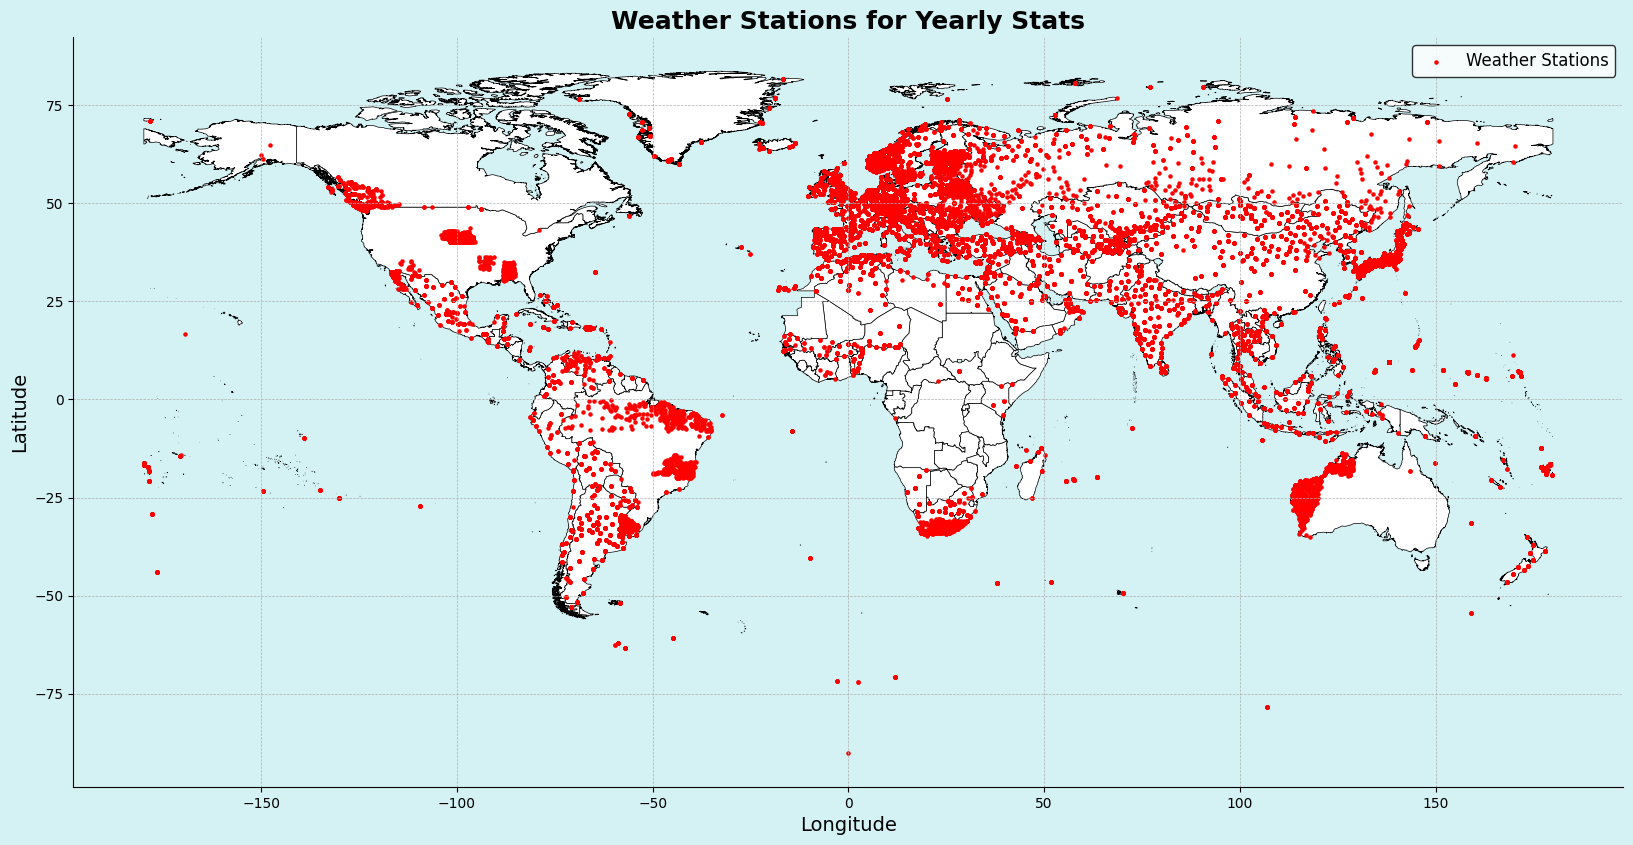

In [9]:
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.patheffects as PathEffects
from matplotlib.patches import Polygon

font_family = "sans"
background_color = "#D4F1F4"
text_color = "#040303"

sns.set_style({
    "axes.facecolor": background_color,
    "figure.facecolor": background_color,
    "font.family": font_family,
    "text.color": text_color,
})

# Load the CSV file
csv_file_path = 'Outputs/merged_weather_country_data_Station_year.csv'
df = pd.read_csv(csv_file_path)

# Ensure the directory exists or create it
import os
save_dir = "Figures"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

# Create a GeoDataFrame from the CSV file
gdf = gpd.GeoDataFrame(
    df, geometry=gpd.points_from_xy(df.longitude, df.latitude), crs="EPSG:4326"
)

# Display the first few rows of the GeoDataFrame
print(gdf.head())

# Load the world map from the Natural Earth dataset
world_shapefile_path = 'Resources/Shapefiles/WB_countries_Admin0_10m.shp'
world = gpd.read_file(world_shapefile_path)

# Create the plot figure with the desired figsize
fig, ax = plt.subplots(1, 1, figsize=(20, 12))

# Plot the world map with countries in white

world.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)

# Plot the weather stations from the CSV
gdf.plot(ax=ax, color='red', markersize=5, label='Weather Stations')

# Add titles and labels
plt.title('Weather Stations for Yearly Stats', fontsize=18, fontweight='bold', color=text_color)
plt.xlabel('Longitude', fontsize=14, color=text_color)
plt.ylabel('Latitude', fontsize=14, color=text_color)

# Customize legend
plt.legend(loc='upper right', fontsize=12, frameon=True, facecolor='white', edgecolor='black')

# Improve the overall aesthetics
ax.set_facecolor(background_color)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Save the figure with the correct file path
plt.savefig(os.path.join(save_dir, "Weather_Stations_all.png"))

# Display the plot
plt.show()



### Find stations within wine regions

In [10]:

from shapely.geometry import Polygon, Point
from shapely.ops import unary_union


# Load the shapefile
shapefile_path = 'Resources/Shapefiles/GlobalVineyards.shp'
gdf_shape = gpd.read_file(shapefile_path)


# Check for stations that did not get lat and long coordinates
stations_df = merged_df.dropna(subset=['latitude', 'longitude'])  # Drop rows with missing coordinates

# Create a GeoDataFrame from the weather station DataFrame
geometry = [Point(xy) for xy in zip(stations_df['longitude'], stations_df['latitude'])]
gdf_stations = gpd.GeoDataFrame(stations_df, geometry=geometry)

# Ensure the GeoDataFrame uses the same coordinate system
gdf_stations.crs = "EPSG:4326"

# Re-project both GeoDataFrames to a projected CRS suitable for distance calculations
projected_crs = "EPSG:3395"  # World Mercator projection
gdf_shape = gdf_shape.to_crs(projected_crs)
gdf_stations = gdf_stations.to_crs(projected_crs)

# Convert distance to meters (500 miles is approximately 804,670 meters)
buffer_distance = 804670  # 500 miles in meters

# Create a buffer around the shapefile geometries
shape_buffer = gdf_shape.geometry.buffer(buffer_distance)

# Combine all buffered shapes into a single geometry
combined_shape_buffer = unary_union(shape_buffer)

# Find weather stations within the buffer
stations_within_buffer = gdf_stations[gdf_stations.geometry.within(combined_shape_buffer)]

# Save the results to a new CSV file
output_file_path = 'Outputs/stations_within_100_miles.csv'
stations_within_buffer.to_csv(output_file_path, index=False)
print(f"Stations within 100 miles exported to {output_file_path}")

# Re-project back to geographic CRS for plotting
stations_within_buffer = stations_within_buffer.to_crs(epsg=4326)
shape_buffer_geo = gpd.GeoSeries([combined_shape_buffer], crs=projected_crs).to_crs(epsg=4326)

# Display the results
stations_within_buffer


Stations within 100 miles exported to Outputs/stations_within_100_miles.csv


,station,date,DP10,DP1X,DT32,DX70,DX90,EMNT,EMXP,EMXT,...,MXPN,PRCP,TAVG,TMAX,code,latitude,longitude,elevation,location,geometry
16,AG000060390,1995,40.0,4.0,3.0,239.0,27.0,31.0,1.60,105.0,...,NaN,21.72,64.5,75.5,AG,36.7167,3.25,24.0,ALGER-DAR EL BEIDA GSN 60390,POINT (3.25000 36.71670)
17,AG000060390,1996,59.0,6.0,2.0,228.0,21.0,29.0,2.56,113.0,...,NaN,31.57,63.6,73.5,AG,36.7167,3.25,24.0,ALGER-DAR EL BEIDA GSN 60390,POINT (3.25000 36.71670)
18,AG000060390,1997,44.0,5.0,0.0,231.0,20.0,33.0,2.08,101.0,...,NaN,21.52,65.0,75.4,AG,36.7167,3.25,24.0,ALGER-DAR EL BEIDA GSN 60390,POINT (3.25000 36.71670)
19,AG000060390,1998,47.0,6.0,4.0,220.0,30.0,30.0,1.92,104.0,...,NaN,23.99,63.7,74.8,AG,36.7167,3.25,24.0,ALGER-DAR EL BEIDA GSN 60390,POINT (3.25000 36.71670)
20,AG000060390,2004,51.0,8.0,NaN,NaN,NaN,NaN,1.85,NaN,...,NaN,25.31,NaN,NaN,AG,36.7167,3.25,24.0,ALGER-DAR EL BEIDA GSN 60390,POINT (3.25000 36.71670)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31182,WA004191820,1999,17.0,1.0,0.0,324.0,158.0,33.0,1.38,105.0,...,NaN,7.24,71.9,85.2,WA,-26.5300,18.12,1077.0,J.G.H. VAN DER WATH AIRP GSN 68312,POINT (18.12000 -26.53000)
31183,WA004191820,2000,12.0,3.0,3.0,327.0,114.0,27.0,1.54,103.0,...,NaN,7.17,69.7,83.6,WA,-26.5300,18.12,1077.0,J.G.H. VAN DER WATH AIRP GSN 68312,POINT (18.12000 -26.53000)
31184,WA004191820,2001,13.0,1.0,1.0,317.0,140.0,27.0,1.14,104.0,...,NaN,5.51,70.4,84.3,WA,-26.5300,18.12,1077.0,J.G.H. VAN DER WATH AIRP GSN 68312,POINT (18.12000 -26.53000)
31185,WA004191820,2002,9.0,0.0,2.0,315.0,153.0,30.0,0.55,105.0,...,NaN,3.94,71.1,84.8,WA,-26.5300,18.12,1077.0,J.G.H. VAN DER WATH AIRP GSN 68312,POINT (18.12000 -26.53000)


### Plot stations within wine regions

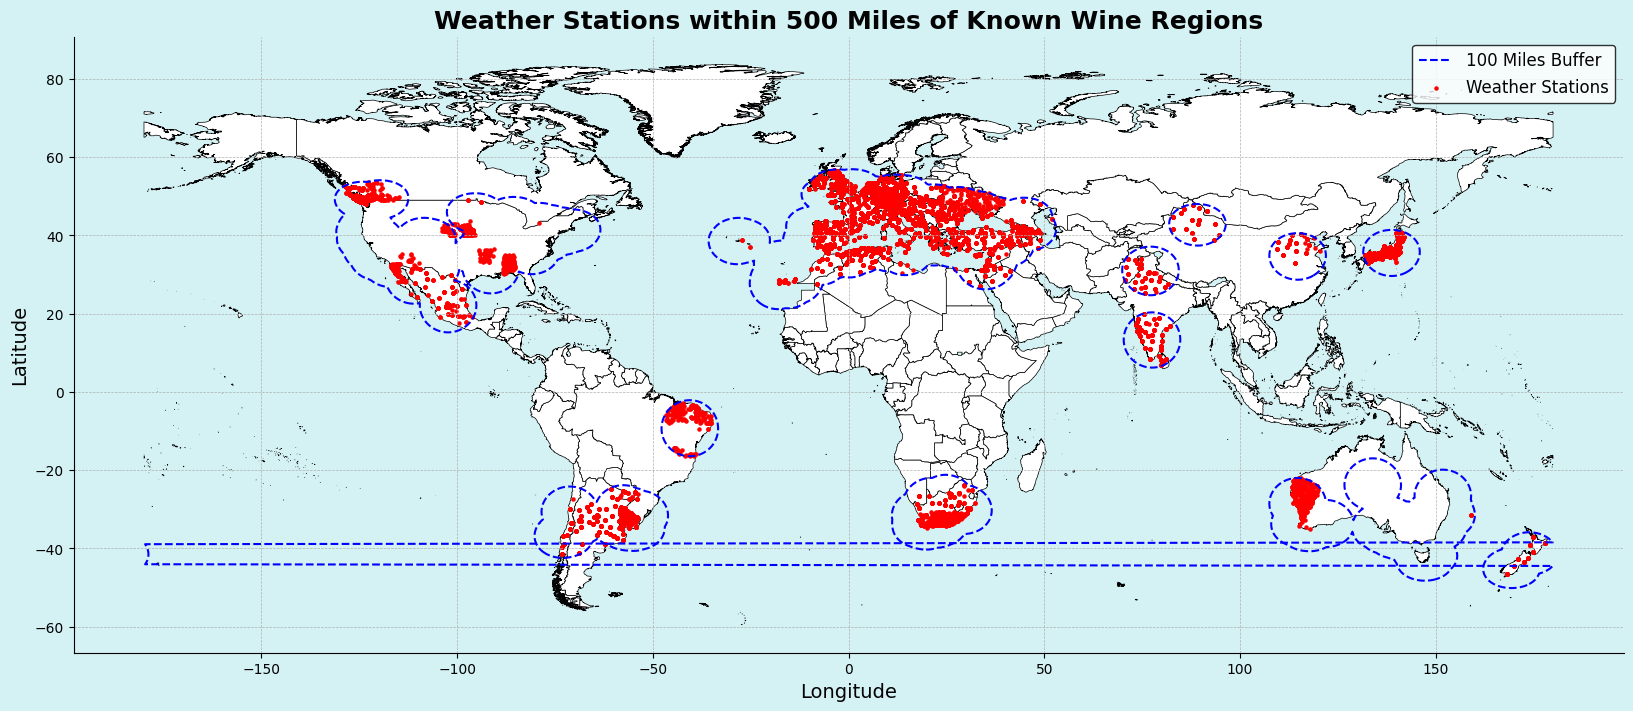

In [11]:
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Customizing the plot's appearance
font_family = "sans"
background_color = "#D4F1F4"
text_color = "#040303"

sns.set_style({
    "axes.facecolor": background_color,
    "figure.facecolor": background_color,
    "font.family": font_family,
    "text.color": text_color,
})

# Load the world map from the Natural Earth dataset
world_shapefile_path = 'Resources/Shapefiles/WB_countries_Admin0_10m.shp'
world = gpd.read_file(world_shapefile_path)

# Re-project world map to match the buffer zone's CRS
world = world.to_crs(epsg=4326)

# Ensure shape_buffer_geo and stations_within_buffer are also in the correct CRS
shape_buffer_geo = shape_buffer_geo.to_crs(epsg=4326)
stations_within_buffer = stations_within_buffer.to_crs(epsg=4326)

# Create the plot
fig, ax = plt.subplots(1, 1, figsize=(20, 12))

# Plot the world map with white countries
world.plot(ax=ax, color='white', edgecolor='black', linewidth=0.5)

# Plot the buffer zone
shape_buffer_geo.boundary.plot(ax=ax, color='blue', linewidth=1.5, linestyle='--', label='100 Miles Buffer')

# Plot the weather stations within the buffer
stations_within_buffer.plot(ax=ax, color='red', markersize=5, label='Weather Stations')

# Add titles and labels
plt.title('Weather Stations within 500 Miles of Known Wine Regions', fontsize=18, fontweight='bold', color=text_color)
plt.xlabel('Longitude', fontsize=14, color=text_color)
plt.ylabel('Latitude', fontsize=14, color=text_color)

# Customize legend
plt.legend(loc='upper right', fontsize=12, frameon=True, facecolor='white', edgecolor='black')

# Improve the overall aesthetics
ax.set_facecolor(background_color)
ax.grid(True, which='both', linestyle='--', linewidth=0.5)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

# Set the aspect of the map to be equal
ax.set_aspect('equal')

# Save the figure with the correct file path
save_dir = "Figures"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)
plt.savefig(os.path.join(save_dir, "Weather_Stations_by_Wine_Regions.png"))

# Display the plot
plt.show()


### Double checking climate file matches up with original start file

In [12]:
import pandas as pd

# Load the weather_all_country_codes3.csv file
weather_file_path = 'Resources/weather_all_country_codes3.csv'
weather_df = pd.read_csv(weather_file_path)

# Load the merged_weather_data.csv file
merged_file_path = 'Outputs/merged_weather_country_data_Station_year.csv'
merged_df = pd.read_csv(merged_file_path)

# Ensure the station identifiers are consistent (e.g., remove 'GHCND:' prefix if necessary)
weather_df['station'] = weather_df['station'].str.replace('GHCND:', '')
merged_df['station'] = merged_df['station'].str.replace('GHCND:', '')

# Calculate the number of unique station IDs in each file
unique_stations_weather = weather_df['station'].nunique()
unique_stations_merged = merged_df['station'].nunique()

print(f"Number of unique stations in weather_all_country_codes3.csv: {unique_stations_weather}")
print(f"Number of unique stations in merged_weather_data.csv: {unique_stations_merged}")


Number of unique stations in weather_all_country_codes3.csv: 6303
Number of unique stations in merged_weather_data.csv: 6303


### Identify all weather stations within 500 miles of a known wine region

In [13]:
import pandas as pd

# Load the merged weather station file
merged_file_path = 'Outputs/merged_weather_country_data_Station_year.csv'
merged_df = pd.read_csv(merged_file_path)

# Load the stations_within_buffer file
stations_within_buffer_file_path = 'Outputs/stations_within_100_miles.csv'
stations_within_buffer = pd.read_csv(stations_within_buffer_file_path)

# Load the wine data file
wine_data_file_path = 'Outputs/Wine_data_Production_cleaned.csv'
wine_df = pd.read_csv(wine_data_file_path)

# Ensure column names are consistent
merged_df.columns = merged_df.columns.str.lower()
stations_within_buffer.columns = stations_within_buffer.columns.str.lower()
wine_df.columns = wine_df.columns.str.lower()

# Rename 'Region/Country' to 'country' in the wine DataFrame
if 'region/country' in wine_df.columns:
    wine_df.rename(columns={'region/country': 'country'}, inplace=True)

# Print column names to verify renaming
print("Merged DataFrame columns:", merged_df.columns)
print("Stations within buffer DataFrame columns:", stations_within_buffer.columns)
print("Wine data DataFrame columns:", wine_df.columns)

# Check if 'country' column exists in stations_within_buffer
if 'country' not in stations_within_buffer.columns:
    # If it does not exist, you need to decide how to handle this case
    # For example, you might want to extract country information from another column
    # or add a default value for the sake of demonstration:
    stations_within_buffer['country'] = 'Unknown'

# Extract unique country codes
unique_countries_wine = set(wine_df['country'].unique())
unique_countries_buffer = set(stations_within_buffer['country'].unique())

# Find countries in wine production data but not in stations within buffer
missing_countries = unique_countries_wine - unique_countries_buffer

# Filter the merged weather data for the missing countries
missing_data = merged_df[merged_df['country'].isin(missing_countries)]

# Save the missing data to a file
missing_data_file_path = 'Outputs/missing_countries_weather_data.csv'
missing_data.to_csv(missing_data_file_path, index=False)
print(f"Missing countries' weather data saved to {missing_data_file_path}")

# Add the missing countries' data back to the stations within the buffer data
updated_buffer_data = pd.concat([stations_within_buffer, missing_data], ignore_index=True)

# Save the updated buffer data
updated_buffer_file_path = 'Outputs/updated_stations_within_100_miles.csv'
updated_buffer_data.to_csv(updated_buffer_file_path, index=False)
print(f"Updated buffer data saved to {updated_buffer_file_path}")

# Display the first few rows of the updated buffer data as a table
print("Updated Buffer Data:")
print(updated_buffer_data.head().to_string(index=False))


Merged DataFrame columns: Index(['station', 'date', 'dp10', 'dp1x', 'dt32', 'dx70', 'dx90', 'emnt',
       'emxp', 'emxt', 'htdd', 'mnpn', 'mxpn', 'prcp', 'tavg', 'tmax', 'code',
       'latitude', 'longitude', 'elevation', 'location', 'country'],
      dtype='object')
Stations within buffer DataFrame columns: Index(['station', 'date', 'dp10', 'dp1x', 'dt32', 'dx70', 'dx90', 'emnt',
       'emxp', 'emxt', 'htdd', 'mnpn', 'mxpn', 'prcp', 'tavg', 'tmax', 'code',
       'latitude', 'longitude', 'elevation', 'location', 'geometry'],
      dtype='object')
Wine data DataFrame columns: Index(['country', 'year', 'quantity_hl', 'gallons', 'code'], dtype='object')
Missing countries' weather data saved to Outputs/missing_countries_weather_data.csv
Updated buffer data saved to Outputs/updated_stations_within_100_miles.csv
Updated Buffer Data:
    station  date  dp10  dp1x  dt32  dx70  dx90  emnt  emxp  emxt   htdd  mnpn  mxpn  prcp  tavg  tmax code  latitude  longitude  elevation                  

### Clean up weather station data to have only an averaged data value for each country by year. 

In [14]:

# Load the CSV file
file_path = 'Outputs/updated_stations_within_100_miles.csv'
data = pd.read_csv(file_path)

# Specify the columns to average and calculate standard deviation
columns_to_average = ['dp10', 'dp1x', 'dt32', 'dx70', 'dx90', 'emnt', 'emxp', 'emxt', 'htdd', 'mnpn', 'mxpn', 'prcp', 'tavg', 'tmax']

# Group by 'country' and 'date', then calculate the mean and standard deviation
grouped_data = data.groupby(['country', 'date'])[columns_to_average].agg(['mean', 'std']).reset_index()

# Flatten the column names
grouped_data.columns = ['_'.join(col).strip('_') for col in grouped_data.columns.values]

# Save the cleaned and grouped data to a new CSV file if needed
output_path = 'Outputs/averages_updated_100_mile_stations.csv'
grouped_data.to_csv(output_path, index=False)

# Display the cleaned and grouped data
grouped_data

/var/folders/_d/q6dl733j0hdfhxbg883rg3xc0000gn/T/ipykernel_44377/3339624356.py:3: DtypeWarning: Columns (21) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv(file_path)


,country,date,dp10_mean,dp10_std,dp1x_mean,dp1x_std,dt32_mean,dt32_std,dx70_mean,dx70_std,...,mnpn_mean,mnpn_std,mxpn_mean,mxpn_std,prcp_mean,prcp_std,tavg_mean,tavg_std,tmax_mean,tmax_std
0,Albania,1995,97.000000,NaN,29.000000,NaN,NaN,NaN,160.0,NaN,...,NaN,NaN,NaN,NaN,90.820000,NaN,NaN,NaN,66.90,NaN
1,Albania,1996,101.000000,NaN,30.000000,NaN,NaN,NaN,173.0,NaN,...,NaN,NaN,NaN,NaN,92.590000,NaN,NaN,NaN,68.70,NaN
2,Albania,1997,70.000000,NaN,16.000000,NaN,NaN,NaN,169.5,12.020815,...,NaN,NaN,NaN,NaN,57.740000,NaN,NaN,NaN,69.65,1.343503
3,Albania,1998,NaN,NaN,NaN,NaN,NaN,NaN,182.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.90,NaN
4,Albania,1999,91.000000,NaN,24.000000,NaN,NaN,NaN,187.5,0.707107,...,NaN,NaN,NaN,NaN,72.340000,NaN,NaN,NaN,71.00,0.424264
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2191,Vietnam,2019,70.285714,20.572751,17.285714,7.825477,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,56.551429,18.578469,NaN,NaN,NaN,NaN
2192,Vietnam,2020,71.285714,16.908719,17.714286,8.826367,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,62.635714,26.536631,NaN,NaN,NaN,NaN
2193,Vietnam,2021,77.000000,6.055301,21.250000,8.845903,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,72.560000,28.564926,NaN,NaN,NaN,NaN
2194,Vietnam,2022,128.000000,NaN,34.000000,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,105.860000,NaN,NaN,NaN,NaN,NaN


### Merge Wine production data with cleaned accounting for region weather data

In [15]:
import pandas as pd

# Load the two CSV files
wine_data = pd.read_csv('Outputs/Wine_data_Production_cleaned.csv')
weather_data = pd.read_csv('Outputs/averages_updated_100_mile_stations.csv')

# Rename columns to prepare for merging
wine_data.rename(columns={'Country': 'country', 'Year': 'year'}, inplace=True)
weather_data.rename(columns={'date': 'year'}, inplace=True)

# Merging the datasets on the 'country' and 'year' column
merged_data = pd.merge(wine_data, weather_data, on=['country', 'year'], how='outer')

# Save the final merged dataframe to a CSV file
output_path = 'Outputs/merged_wine_weather_for_regions_data.csv'
merged_data.to_csv(output_path, index=False)

# Identify unmatched wine data
# Extract country columns
merged_countries = weather_data['country'].unique()
wine_data_all_countries = wine_data['country'].unique()

# Convert to sets for easy comparison
merged_countries_set = set(merged_countries)
wine_data_all_countries_set = set(wine_data_all_countries)

# Find common and unique countries
common_countries = merged_countries_set & wine_data_all_countries_set
unique_to_merged = merged_countries_set - wine_data_all_countries_set
unique_to_wine_data_all = wine_data_all_countries_set - merged_countries_set

# Count the countries in each category
common_countries_count = len(common_countries)
unique_to_merged_count = len(unique_to_merged)
unique_to_wine_data_all_count = len(unique_to_wine_data_all)

# Results
print("Countries present in both datasets:", common_countries_count)
print("Countries unique to the weather:", unique_to_merged_count)
print("Countries unique to the wine data all dataset:", unique_to_wine_data_all_count)

# Lists of unique countries
unique_to_merged_countries = list(unique_to_merged)
unique_to_wine_data_all_countries = list(unique_to_wine_data_all)

print("Countries unique to the weather dataset:", unique_to_merged_countries)
print("Countries unique to the wine data all dataset:", unique_to_wine_data_all_countries)


Countries present in both datasets: 127
Countries unique to the weather: 1
Countries unique to the wine data all dataset: 58
Countries unique to the weather dataset: ['Unknown']
Countries unique to the wine data all dataset: ['Nicaragua', 'Bahrain', 'Equatorial Guinea', 'Norfolk Island', 'Mauritania', 'Eritrea', 'Afghanistan', 'Panama', 'Chad', 'Angola', 'Uganda', 'Cambodia', 'Korea (the Republic of)', 'Cook Islands', 'Guinea', 'Niue', 'Congo (the Democratic Republic of the)', 'Reunion island', 'Sierra Leone', 'Republic of North Macedonia', 'Ecuador', 'Luxemburg', 'China, mainland', 'Antigua and Barbuda', 'Barbados', 'Zimbabwe', 'Burundi', 'Saint Lucia', 'Guinea-Bissau', 'Liberia', 'South Sudan', 'Rwanda', 'Gabon', 'Syrian Arab Republic', 'Gambia', 'Malawi', 'Lesotho', 'Tonga', 'Tuvalu', 'Iraq', "Korea (the Democratic People's Republic of)", 'Serbia And Montenegro', 'Brunei Darussalam', "Lao People's Democratic Republic", 'Ethiopia', 'Kiribati', 'Congo', 'Nigeria', 'Cameroon', 'Guadelo

# Analysis
### Exploring Wine Production

Total wine production for all countries combined from 1995 to 2023

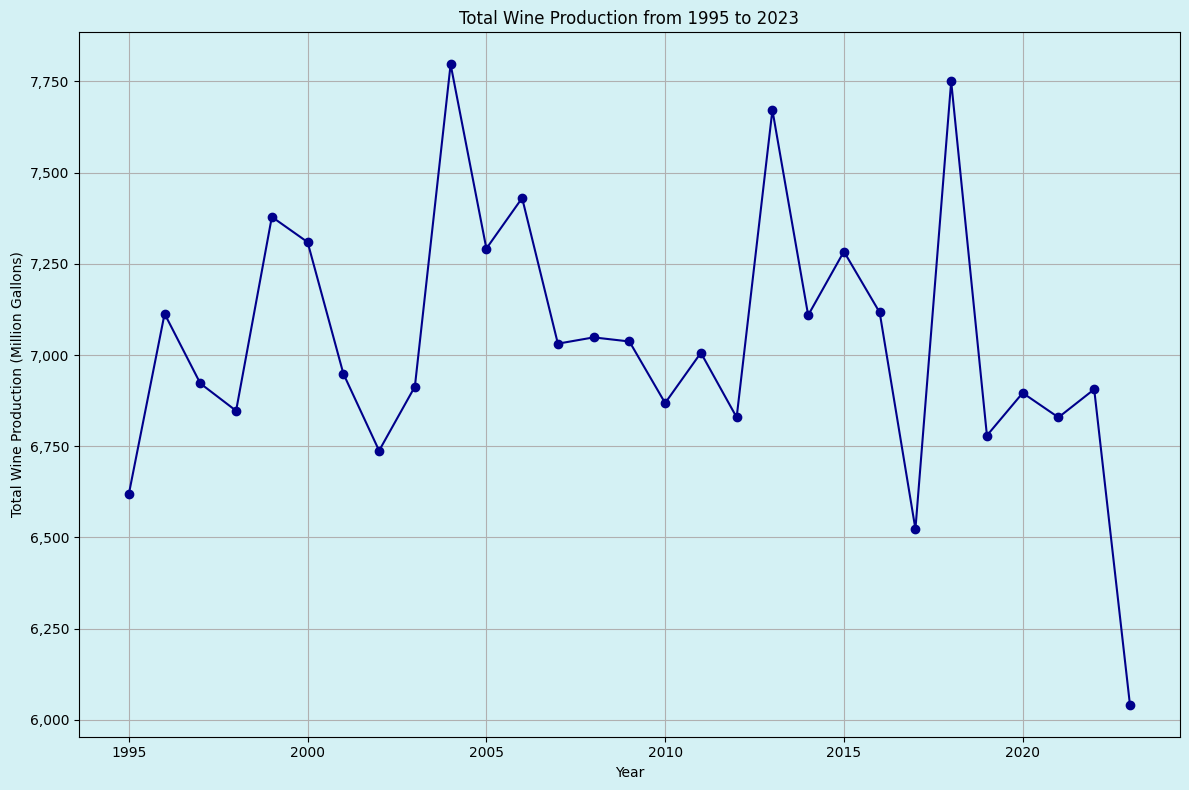

In [16]:
# Filter the data to include only wine production records
wine_production_df = wine_country_weather_data_final_df[wine_country_weather_data_final_df['Variable'] == 'Production']
wine_production_path = 'Outputs/Wine_data_all_Production.csv'
wine_production_df.to_csv(wine_production_path, index=False)
# Group by Year and sum the Quantity_gallons
wine_production_by_year = wine_production_df.groupby('Year')['Quantity_gallons'].sum().reset_index()

# Convert the Quantity_gallons to millions
wine_production_by_year['Quantity_gallons_million'] = wine_production_by_year['Quantity_gallons'] / 1e6

# Define a function to format the y-axis values with thousand commas
def millions_formatter(x, pos):
    return f'{x:,.0f}'

# Create the line plot
plt.figure(figsize=(12, 8))
plt.plot(wine_production_by_year['Year'], wine_production_by_year['Quantity_gallons_million'], marker='o', linestyle='-', color='darkblue')

# Customize the plot
plt.xlabel('Year')
plt.ylabel('Total Wine Production (Million Gallons)')
plt.title('Total Wine Production from 1995 to 2023')
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.grid(True)
plt.tight_layout()

plt.savefig('Figures/WineProduction1995-2023.png')
# Show the plot
plt.show()


Map of total wine production by country in 1995

In [17]:
import kaleido

# Filter the data to include only wine production records and for the year 1995
wine_production_1995_df = wine_country_weather_data_final_df[(wine_country_weather_data_final_df['Variable'] == 'Production') & (wine_country_weather_data_final_df['Year'] == 1995)]

# Group by Region/Country and sum the Quantity_gallons
wine_production_1995_by_country = wine_production_1995_df.groupby('Region/Country')['Quantity_gallons'].sum().reset_index()

# Create the choropleth map
fig = px.choropleth(
    wine_production_1995_by_country,
    locations="Region/Country",
    locationmode="country names",
    color="Quantity_gallons",
    hover_name="Region/Country",
    color_continuous_scale=px.colors.sequential.OrRd,
    labels={'Quantity_gallons': 'Total Wine Production (Gallons)'},
    title='Total Wine Production by Country in 1995'
)

# Customize the layout
fig.update_layout(
    geo=dict(showframe=False, showcoastlines=False, projection_type='equirectangular'),
    margin={"r":0,"t":30,"l":0,"b":0}
)

# Show the plot
fig.show()

fig.write_image("Outputs/wine_production_1995_map.png")

Map of total wine production by country in 2023

In [18]:
#  Filter the data to include only wine production records and for the year 2023
wine_production_2023_df = wine_country_weather_data_final_df[(wine_country_weather_data_final_df['Variable'] == 'Production') & (wine_country_weather_data_final_df['Year'] == 2023)]

# Group by Region/Country and sum the Quantity_gallons
wine_production_2023_by_country = wine_production_2023_df.groupby('Region/Country')['Quantity_gallons'].sum().reset_index()

# Create the choropleth map
fig = px.choropleth(
    wine_production_2023_by_country,
    locations="Region/Country",
    locationmode="country names",
    color="Quantity_gallons",
    hover_name="Region/Country",
    color_continuous_scale=px.colors.sequential.OrRd,
    labels={'Quantity_gallons': 'Total Wine Production (Gallons)'},
    title='Total Wine Production by Country in 2023'
)

# Customize the layout
fig.update_layout(
    geo=dict(showframe=False, showcoastlines=False, projection_type='equirectangular'),
    margin={"r":0,"t":30,"l":0,"b":0}
)

# Show the plot
fig.show()


# Question 1: Which were the top wine producing countries from year 1995?

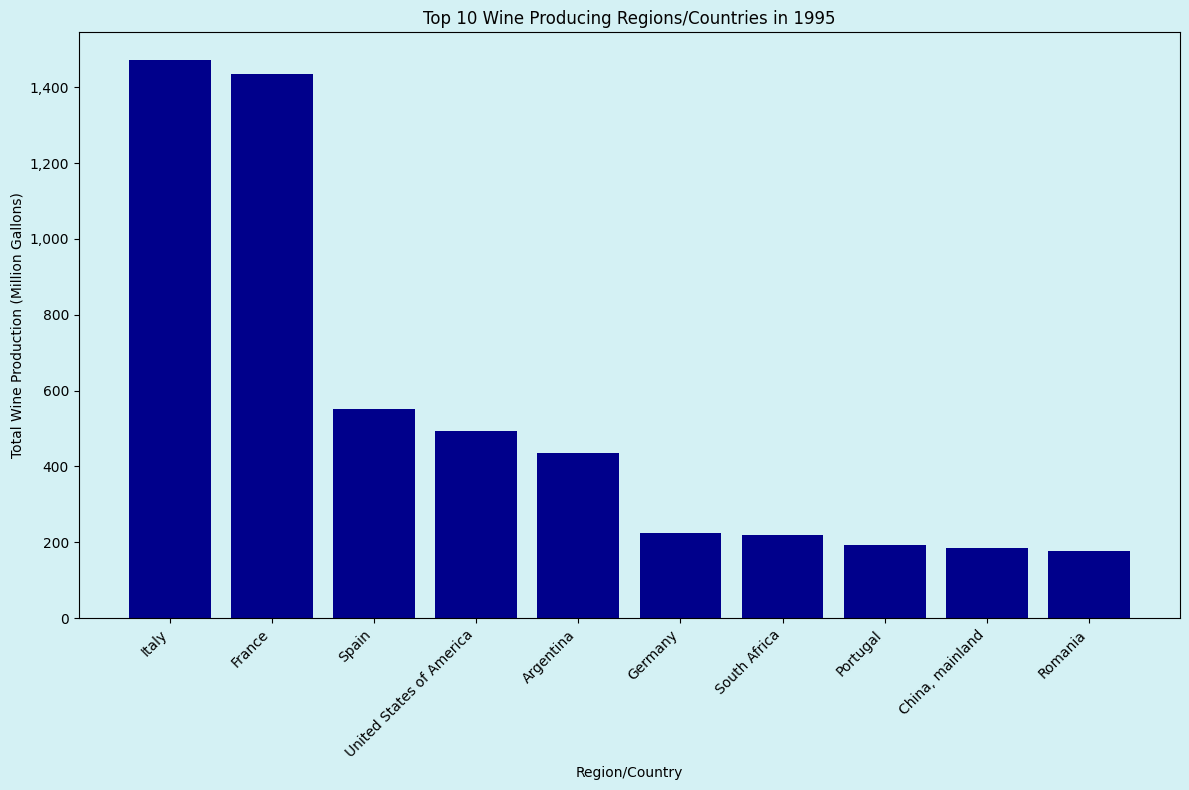

In [19]:
# Filter the data to include only wine production records and for the year 1995
wine_production_df = wine_country_weather_data_final_df[(wine_country_weather_data_final_df['Variable'] == 'Production') & (wine_country_weather_data_final_df['Year'] == 1995)]

# Group by Region/Country and sum the Quantity_gallons
wine_production_by_region = wine_production_df.groupby('Region/Country')['Quantity_gallons'].sum().reset_index()

# Convert the Quantity_gallons to millions
wine_production_by_region['Quantity_gallons_million'] = wine_production_by_region['Quantity_gallons'] / 1e6

# Sort the values in descending order and get the top 10
top_10_wine_producing_regions = wine_production_by_region.sort_values(by='Quantity_gallons_million', ascending=False).head(10)

# Define a function to format the y-axis values with thousand commas
def millions_formatter(x, pos):
    return f'{x:,.0f}'

# Create the bar chart
plt.figure(figsize=(12, 8))
plt.bar(top_10_wine_producing_regions['Region/Country'], top_10_wine_producing_regions['Quantity_gallons_million'], color='darkblue')
plt.xlabel('Region/Country')
plt.ylabel('Total Wine Production (Million Gallons)')
plt.title('Top 10 Wine Producing Regions/Countries in 1995')
plt.xticks(rotation=45, ha='right')  # Rotate the x labels for better readability
plt.gca().yaxis.set_major_formatter(FuncFormatter(millions_formatter))
plt.tight_layout()  # Adjust layout to make room for rotated x labels
plt.show()

### A: The top three wine producers in 1995 were Italy, France, and Spain

# Question 2: Which were the top wine producing countries from year 2023?

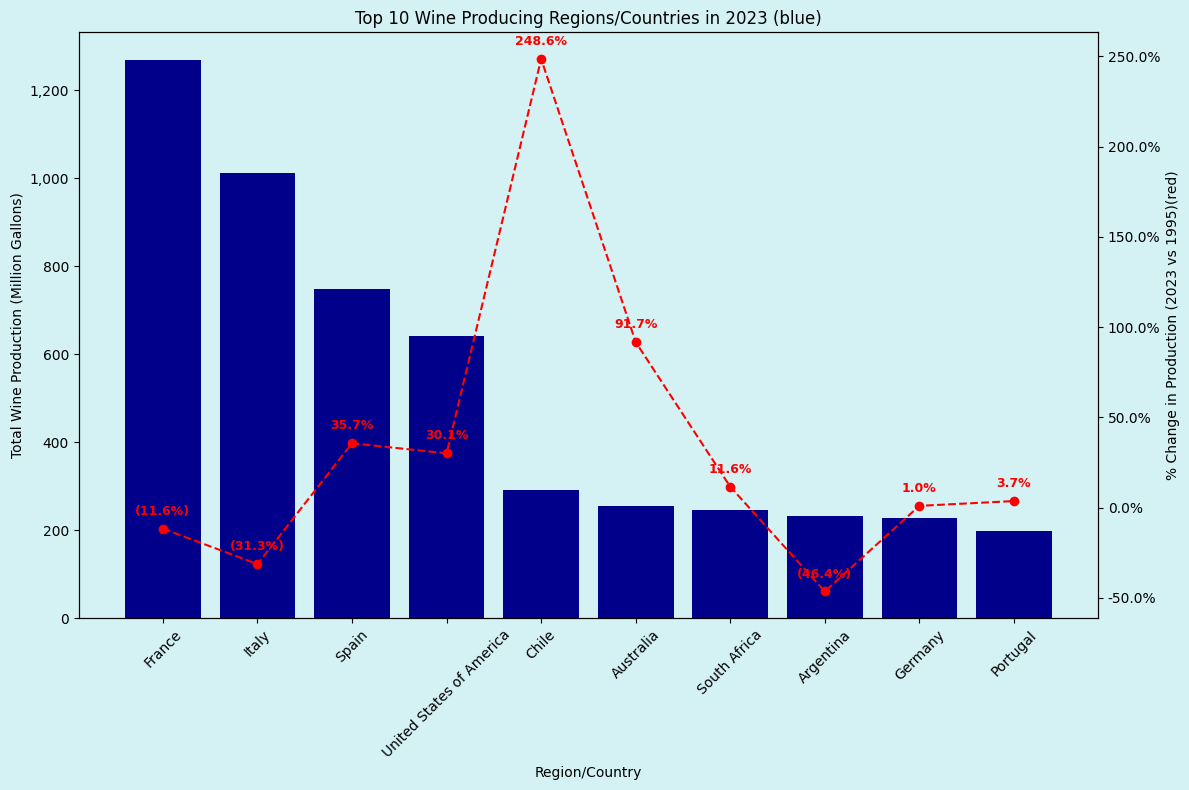

In [20]:
# Filter the data to include only wine production records and for the year 1995
wine_production_df_1995 = wine_country_weather_data_final_df[(wine_country_weather_data_final_df['Variable'] == 'Production') & (wine_country_weather_data_final_df['Year'] == 1995)]

# Filter the data to include only wine production records and for the year 2023
wine_production_df_2023 = wine_country_weather_data_final_df[(wine_country_weather_data_final_df['Variable'] == 'Production') & (wine_country_weather_data_final_df['Year'] == 2023)]

# Group by Region/Country and sum the Quantity_gallons for 1995 and 2023
wine_production_by_region_1995 = wine_production_df_1995.groupby('Region/Country')['Quantity_gallons'].sum().reset_index()
wine_production_by_region_2023 = wine_production_df_2023.groupby('Region/Country')['Quantity_gallons'].sum().reset_index()

# Merge the two dataframes on Region/Country
wine_production_comparison = pd.merge(wine_production_by_region_1995, wine_production_by_region_2023, on='Region/Country', suffixes=('_1995', '_2023'))

# Calculate the percentage change
wine_production_comparison['Percentage_change'] = ((wine_production_comparison['Quantity_gallons_2023'] - wine_production_comparison['Quantity_gallons_1995']) / wine_production_comparison['Quantity_gallons_1995']) * 100

# Convert the Quantity_gallons_2023 to millions for plotting
wine_production_comparison['Quantity_gallons_2023_million'] = wine_production_comparison['Quantity_gallons_2023'] / 1e6

# Sort the values in descending order and get the top 10
top_10_wine_producing_regions = wine_production_comparison.sort_values(by='Quantity_gallons_2023_million', ascending=False).head(10)

# Define a function to format the y-axis values with thousand commas
def millions_formatter(x, pos):
    return f'{x:,.0f}'

# Define a function to format the percentage change values with one decimal place
def percentage_formatter(x, pos):
    return f'{x:,.1f}%'

# Create the bar chart
fig, ax1 = plt.subplots(figsize=(12, 8))

ax1.bar(top_10_wine_producing_regions['Region/Country'], top_10_wine_producing_regions['Quantity_gallons_2023_million'], color='darkblue')
ax1.set_xlabel('Region/Country')
ax1.set_ylabel('Total Wine Production (Million Gallons)')
ax1.set_title('Top 10 Wine Producing Regions/Countries in 2023 (blue)')
ax1.yaxis.set_major_formatter(FuncFormatter(millions_formatter))
ax1.tick_params(axis='x', rotation=45)

# Create the secondary axis
ax2 = ax1.twinx()
ax2.plot(top_10_wine_producing_regions['Region/Country'], top_10_wine_producing_regions['Percentage_change'], color='red', marker='o', linestyle='--')
ax2.set_ylabel('% Change in Production (2023 vs 1995)(red)')
ax2.yaxis.set_major_formatter(FuncFormatter(percentage_formatter))

# Add data labels to the line graph
for i, txt in enumerate(top_10_wine_producing_regions['Percentage_change']):
    label = f'{txt:.1f}%' if txt >= 0 else f'({-txt:.1f}%)'
    ax2.annotate(label, (top_10_wine_producing_regions['Region/Country'].iloc[i], top_10_wine_producing_regions['Percentage_change'].iloc[i]), 
                 textcoords="offset points", xytext=(0,10), ha='center', fontsize=9, color='red', fontweight='bold')

plt.tight_layout() 
plt.savefig('Outputs/Top10in 2023.png', dpi=300, bbox_inches='tight')
plt.show()



### A: The top three wine producing countries in 2023 are the same three as 1995, but with France in the lead. 
The above graph shoes the top 10 countries, with a red line indicating the precent change in production for each country from 1995 to 2023

# Are there any statistically significant relationships between climate and wine production?


In [21]:
#Region data set
file_path = 'Outputs/merged_wine_weather_for_regions_data.csv'
region_data_all = pd.read_csv(file_path)

# Max temperature
# We only care about data that is not NaN
r_tmax_ww_df = region_data_all[region_data_all['tmax_mean'].notna()]

r_tmax_ww_df.head()

,country,year,Quantity_hl,Gallons,code,dp10_mean,dp10_std,dp1x_mean,dp1x_std,dt32_mean,...,mnpn_mean,mnpn_std,mxpn_mean,mxpn_std,prcp_mean,prcp_std,tavg_mean,tavg_std,tmax_mean,tmax_std
28,Albania,1995,169.0,4464506.8,AL,97.0,NaN,29.0,NaN,NaN,...,NaN,NaN,NaN,NaN,90.82,NaN,NaN,NaN,66.90,NaN
29,Albania,1996,293.0,7740239.6,AL,101.0,NaN,30.0,NaN,NaN,...,NaN,NaN,NaN,NaN,92.59,NaN,NaN,NaN,68.70,NaN
30,Albania,1997,168.0,4438089.6,AL,70.0,NaN,16.0,NaN,NaN,...,NaN,NaN,NaN,NaN,57.74,NaN,NaN,NaN,69.65,1.343503
31,Albania,1998,105.0,2773806.0,AL,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,70.90,NaN
32,Albania,1999,127.0,3354984.4,AL,91.0,NaN,24.0,NaN,NaN,...,NaN,NaN,NaN,NaN,72.34,NaN,NaN,NaN,71.00,0.424264


# 3. What is the correlation between temperature and wine production?

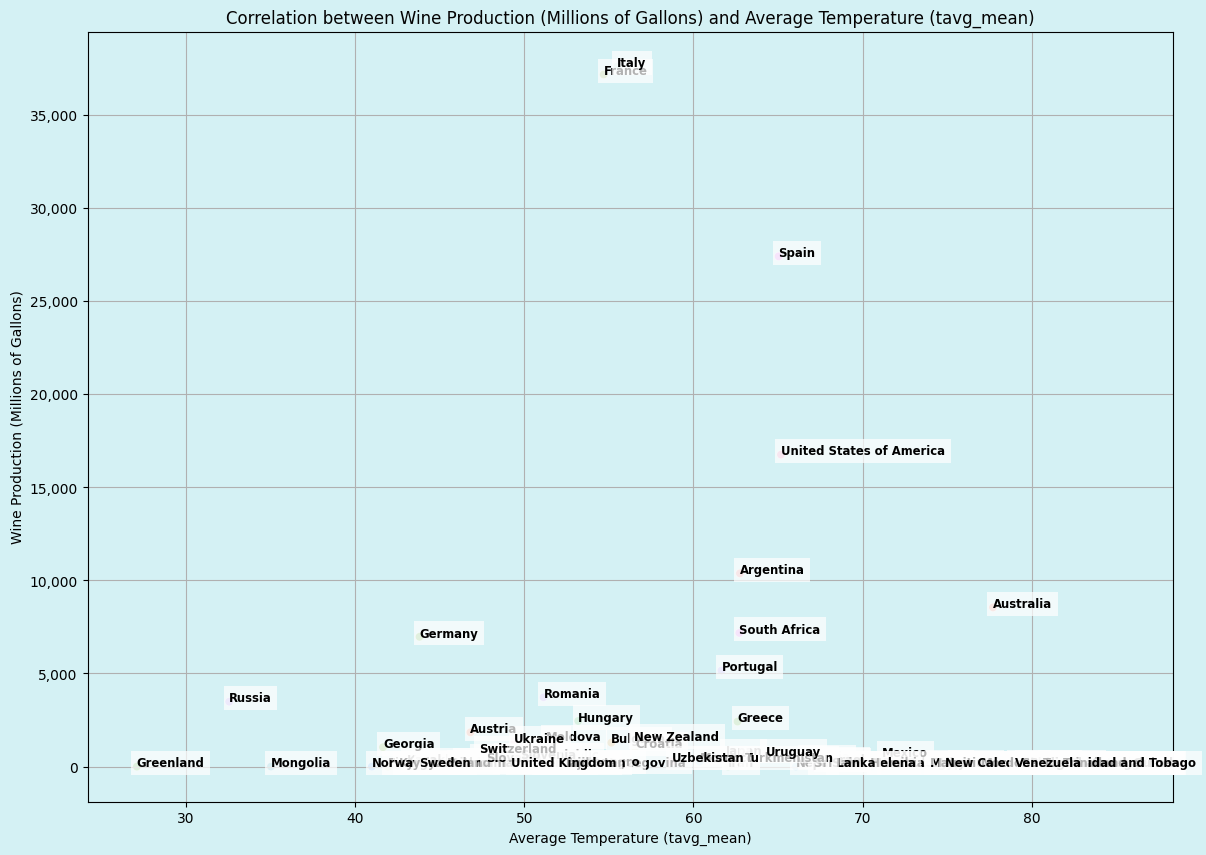

In [22]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data
file_path = 'Outputs/merged_wine_weather_for_regions_data.csv'
wine_weather_data = pd.read_csv(file_path)

# Filter the data for the years 1995 to 2023
filtered_data = wine_weather_data[(wine_weather_data['year'] >= 1995) & (wine_weather_data['year'] <= 2023)]

# Drop rows with missing production values
filtered_data = filtered_data.dropna(subset=['Gallons'])

# Aggregate total production and average temperature by country
aggregated_data = filtered_data.groupby('country').agg({
    'Gallons': 'sum',
    'tavg_mean': 'mean'
}).reset_index()

# Remove rows with infinite or NaN values in 'tavg_mean' or 'Gallons'
aggregated_data = aggregated_data[np.isfinite(aggregated_data['tavg_mean']) & np.isfinite(aggregated_data['Gallons'])]

# Plot the scatter plot
plt.figure(figsize=(14, 10))
sns.scatterplot(x='tavg_mean', y=aggregated_data['Gallons'] / 1e6, data=aggregated_data, alpha=0.5, hue='country', legend=False)

# Add country labels with improved visibility
for line in range(0, aggregated_data.shape[0]):
    plt.text(aggregated_data.tavg_mean.iloc[line], aggregated_data['Gallons'].iloc[line] / 1e6, 
             aggregated_data.country.iloc[line], 
             horizontalalignment='left', 
             size='small', color='black', weight='semibold',
             bbox=dict(facecolor='white', alpha=0.7, edgecolor='none'))

plt.title('Correlation between Wine Production (Millions of Gallons) and Average Temperature (tavg_mean)')
plt.xlabel('Average Temperature (tavg_mean)')
plt.ylabel('Wine Production (Millions of Gallons)')

# Format y-axis with commas for thousands
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, loc: "{:,}".format(int(x))))

plt.grid(True)

# Save the figure to a PNG file
plt.savefig('Outputs/wine_production_vs_temperature.png', dpi=300, bbox_inches='tight')


plt.show()




Analysis
- There is no clear linear relationship between average temperature and wine production based on the scatter plot. Countries with both high and low average temperatures can be seen with varying levels of wine production.
- Top producing countries fall within the 55 - 65 degree range but since there are other countries who also have the same temperature levels for greater production, this suggests that other factors might play a significant role in wine production levels.
- Potentially factors which can include soil quality, sunlight exposure, precipitation, irrigation, wind, humidity, grape varieties, vineyard management protocols, general expertise, and technology.

### Violin Plots and Normalizing the data

Overall Correlations for Increasing Production:
dp10_mean   -0.202934
dp1x_mean   -0.036333
dt32_mean   -0.207175
prcp_mean   -0.137159
tavg_mean    0.179459
tmax_mean    0.151348
Gallons      1.000000
Name: Gallons, dtype: float64

Overall Correlations for Decreasing Production:
dp10_mean   -0.000088
dp1x_mean   -0.082317
dt32_mean   -0.101948
prcp_mean   -0.056192
tavg_mean    0.022681
tmax_mean   -0.007828
Gallons      1.000000
Name: Gallons, dtype: float64


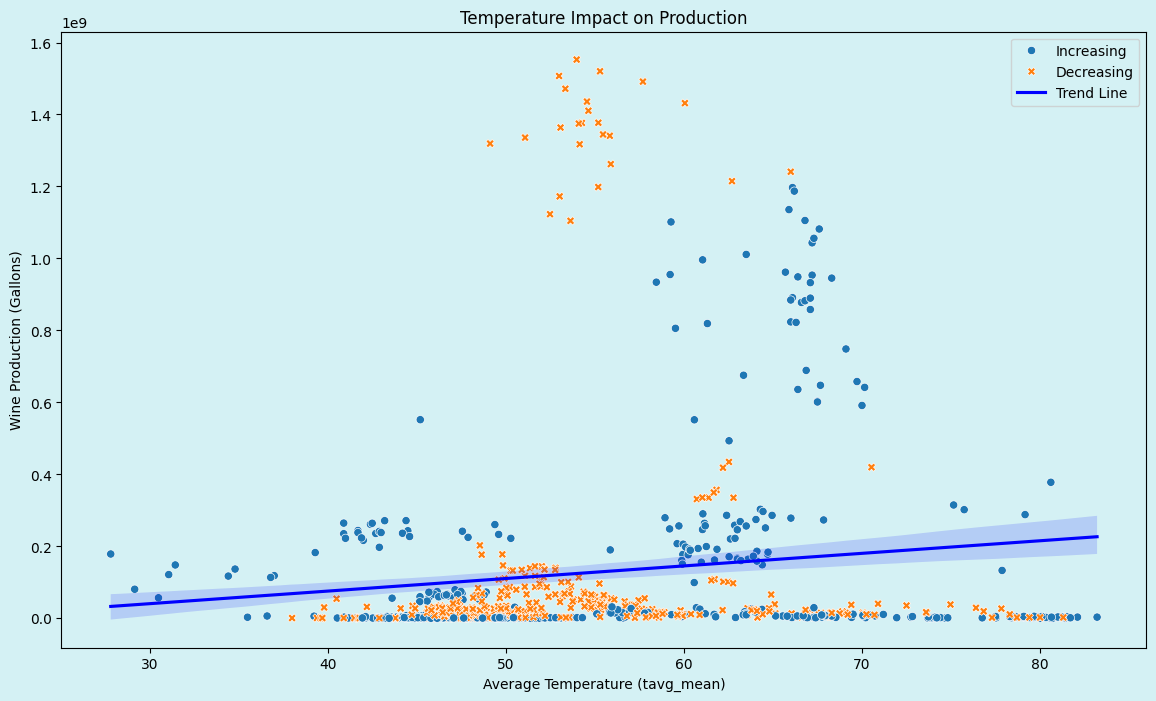

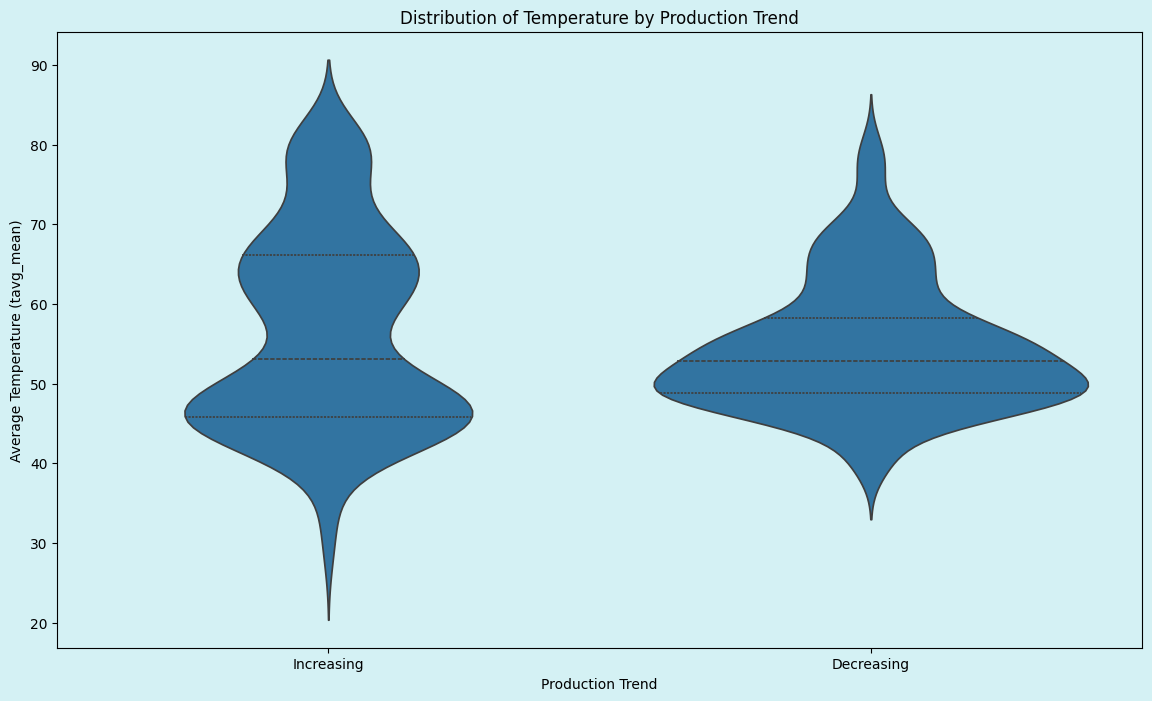

In [23]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# Load the dataset
file_path = 'Outputs/merged_wine_weather_for_regions_data.csv'
data = pd.read_csv(file_path)

# Filter out rows where production data is not available
filtered_data = data.dropna(subset=['Gallons'])

# Ensure the data is sorted by year
filtered_data = filtered_data.sort_values(by=['country', 'year'])

# Calculate the mean production by country and year
mean_production = filtered_data.groupby(['country', 'year'])['Gallons'].mean().reset_index()

# Calculate the change in production for each country
mean_production['production_change'] = mean_production.groupby('country')['Gallons'].diff()

# Remove countries with essentially zero production
non_zero_production_countries = mean_production.groupby('country')['Gallons'].mean()
non_zero_production_countries = non_zero_production_countries[non_zero_production_countries > 0].index

filtered_data = filtered_data[filtered_data['country'].isin(non_zero_production_countries)]

# Recalculate production changes
mean_production = filtered_data.groupby(['country', 'year'])['Gallons'].mean().reset_index()
mean_production['production_change'] = mean_production.groupby('country')['Gallons'].diff()

# Separate countries into those with increasing production and those with decreasing/stopped production
increasing_production_countries = mean_production.groupby('country')['production_change'].sum()
increasing_production_countries = increasing_production_countries[increasing_production_countries > 0].index

decreasing_production_countries = mean_production.groupby('country')['production_change'].sum()
decreasing_production_countries = decreasing_production_countries[decreasing_production_countries <= 0].index

# Filter data for these countries
increasing_data = filtered_data[filtered_data['country'].isin(increasing_production_countries)]
decreasing_data = filtered_data[filtered_data['country'].isin(decreasing_production_countries)]

# Define the climate factors
climate_factors_mean = ['dp10_mean', 'dp1x_mean', 'dt32_mean', 'mnpn_mean', 'mxpn_mean', 'prcp_mean', 'tavg_mean', 'tmax_mean']

# Remove columns with no observed values
valid_climate_factors = [col for col in climate_factors_mean if col in filtered_data.columns and filtered_data[col].notna().any()]

# Function to impute missing data and normalize
def impute_and_normalize(data):
    imputer = SimpleImputer(strategy='mean')
    scaler = StandardScaler()
    
    # Impute missing values
    imputed_data = imputer.fit_transform(data[valid_climate_factors + ['Gallons']])
    
    # Normalize data
    normalized_data = scaler.fit_transform(imputed_data)
    
    # Convert back to DataFrame
    normalized_df = pd.DataFrame(normalized_data, columns=valid_climate_factors + ['Gallons'], index=data.index)
    
    # Ensure all original columns are retained
    for col in data.columns.difference(valid_climate_factors + ['Gallons']):
        normalized_df[col] = data[col]
    
    return normalized_df

# Impute and normalize the data
normalized_increasing_data = impute_and_normalize(increasing_data.copy())
normalized_decreasing_data = impute_and_normalize(decreasing_data.copy())

# Function to calculate correlation between production and climate factors
def calculate_correlations(data):
    correlations = data[valid_climate_factors + ['Gallons']].corr()
    return correlations

# Calculate overall correlations for increasing and decreasing production data
increasing_correlations = calculate_correlations(normalized_increasing_data)
decreasing_correlations = calculate_correlations(normalized_decreasing_data)

# Extract correlation values for 'Gallons'
increasing_corr_values = increasing_correlations['Gallons']
decreasing_corr_values = decreasing_correlations['Gallons']

# Print overall correlations for both increasing and decreasing production
print("Overall Correlations for Increasing Production:")
print(increasing_corr_values)
print("\nOverall Correlations for Decreasing Production:")
print(decreasing_corr_values)

# Filter significant correlations
significant_threshold = 0.5
top_increasing_correlations = increasing_corr_values[abs(increasing_corr_values) > significant_threshold]
top_decreasing_correlations = decreasing_corr_values[abs(decreasing_corr_values) > significant_threshold]

# Combine top factors from both increasing and decreasing production countries
top_factors = list(set(top_increasing_correlations.index).union(set(top_decreasing_correlations.index)))

# Ensure top factors are actually climate factors
top_factors = [factor for factor in top_factors if factor in filtered_data.columns]

# Remove rows with missing values in top factors
filtered_data_cleaned = filtered_data.dropna(subset=top_factors)

# Create a column to label whether production is increasing or decreasing/stopped
filtered_data_cleaned['production_trend'] = filtered_data_cleaned['country'].apply(
    lambda x: 'Increasing' if x in increasing_production_countries else 'Decreasing'
)

# Plot scatter plots with regression lines for temperature impact on production
plt.figure(figsize=(14, 8))
sns.scatterplot(data=filtered_data_cleaned, x='tavg_mean', y='Gallons', hue='production_trend', style='production_trend')
sns.regplot(data=filtered_data_cleaned, x='tavg_mean', y='Gallons', scatter=False, color='blue', label='Trend Line')
plt.title('Temperature Impact on Production')
plt.xlabel('Average Temperature (tavg_mean)')
plt.ylabel('Wine Production (Gallons)')
plt.legend()
plt.show()

# Plot violin plot for temperature distribution across production trends
plt.figure(figsize=(14, 8))
sns.violinplot(x='production_trend', y='tavg_mean', data=filtered_data_cleaned, inner='quartile')
plt.title('Distribution of Temperature by Production Trend')
plt.xlabel('Production Trend')
plt.ylabel('Average Temperature (tavg_mean)')
plt.show()


Results:  
  
For increasing production:  
    - Average temperatures and max temperatures both show positive correlations, indicating that areas with warmer climates may see better production.  
  
For Decreasing production:  
    - The weak correlations overall for this dataset, speak to other factors having greater impacts on decreased wine production.

# 4. What is the correlation between precipitation and wine production?

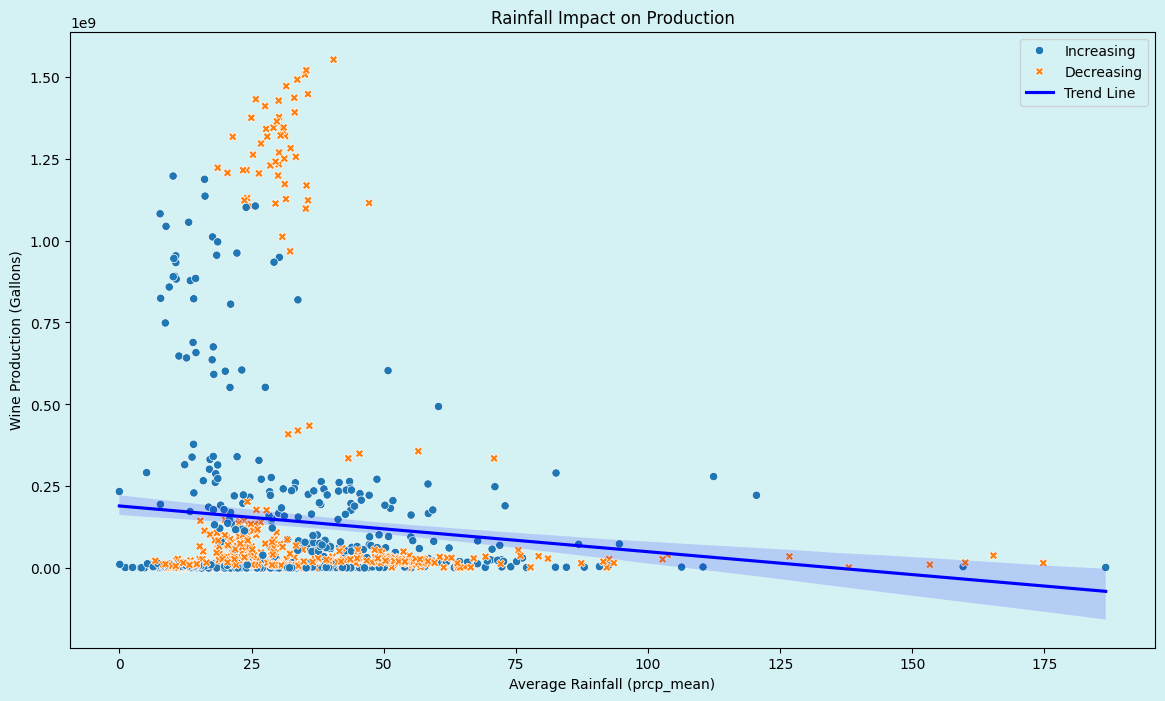

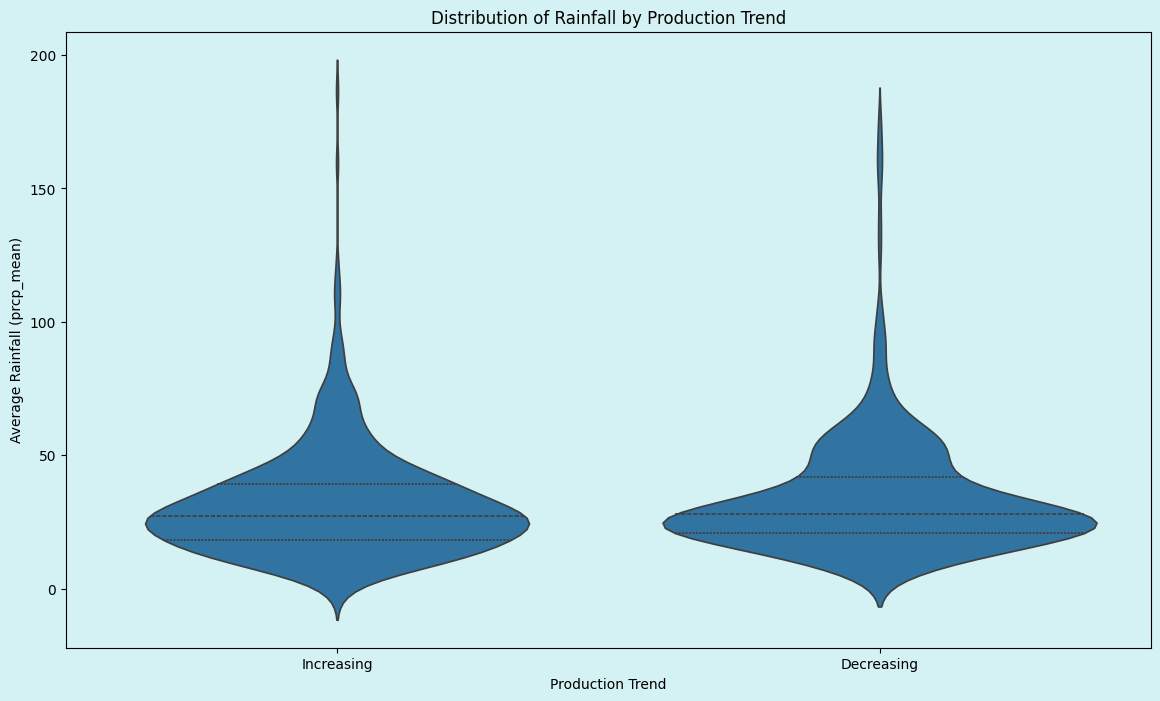

In [24]:
# Plot scatter plots with regression lines for rainfall impact on production
plt.figure(figsize=(14, 8))
sns.scatterplot(data=filtered_data_cleaned, x='prcp_mean', y='Gallons', hue='production_trend', style='production_trend')
sns.regplot(data=filtered_data_cleaned, x='prcp_mean', y='Gallons', scatter=False, color='blue', label='Trend Line')
plt.title('Rainfall Impact on Production')
plt.xlabel('Average Rainfall (prcp_mean)')
plt.ylabel('Wine Production (Gallons)')
plt.legend()
plt.show()

# Plot violin plot for rainfall distribution across production trends
plt.figure(figsize=(14, 8))
sns.violinplot(x='production_trend', y='prcp_mean', data=filtered_data_cleaned, inner='quartile')
plt.title('Distribution of Rainfall by Production Trend')
plt.xlabel('Production Trend')
plt.ylabel('Average Rainfall (prcp_mean)')
plt.show()


Results:  
  
For increasing production:  
    - In areas with increasing productions, results show that frequent rain of any type, can hinder production
  
For Decreasing production:  
    - In these ares, precipitation seems to have little to no impact

Why Normalize the data?  
  
Despite our best efforts obtaining world wide historical climate data, there was a lot of missing values for many of the countries. To smooth this influence out of our data and still conduct some meaningful analysis, it was recommended that we try normalizing the data.  To normalize the data means to in part, to bring all data to a common scale. For instance, if you are examining changes in temperature for two areas, and one is twice as large, change in temperature over a whole country like Australia, compared to change in a city like San Francisco. One way to normalize this data would be by size of the area being measured. This is done by taking the temperature change value and dividing it by the size of the area. The resulting values are "normalized" and now the change can be more fairly compared.
    
To normalize this data, it was important to fill in missing values with the average value of each data type. So for temperature, the overall average temp was calculated, and used to fill in missing values. These values were then standardized using scalar.fit_transform on the newly added data. This scalar transforms the added values to have an average of 0 and a standard deviation of 1.  
  
References:  
[StandardScaler](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html)  

[Data Normalization](https://www.simplilearn.com/automated-recruiting-in-companies-article)

# 5. What is the optimal temperature for maximum production?

Correlation Matrix:
             Quantity_hl  tavg_mean  tmax_mean  dt32_mean  dx70_mean  \
Quantity_hl     1.000000  -0.054011  -0.055756  -0.080665  -0.092454   
tavg_mean      -0.054011   1.000000   0.981134  -0.892459   0.951667   
tmax_mean      -0.055756   0.981134   1.000000  -0.873118   0.961948   
dt32_mean      -0.080665  -0.892459  -0.873118   1.000000  -0.774734   
dx70_mean      -0.092454   0.951667   0.961948  -0.774734   1.000000   
dx90_mean      -0.136819   0.724561   0.773820  -0.526353   0.712501   

             dx90_mean  
Quantity_hl  -0.136819  
tavg_mean     0.724561  
tmax_mean     0.773820  
dt32_mean    -0.526353  
dx70_mean     0.712501  
dx90_mean     1.000000  


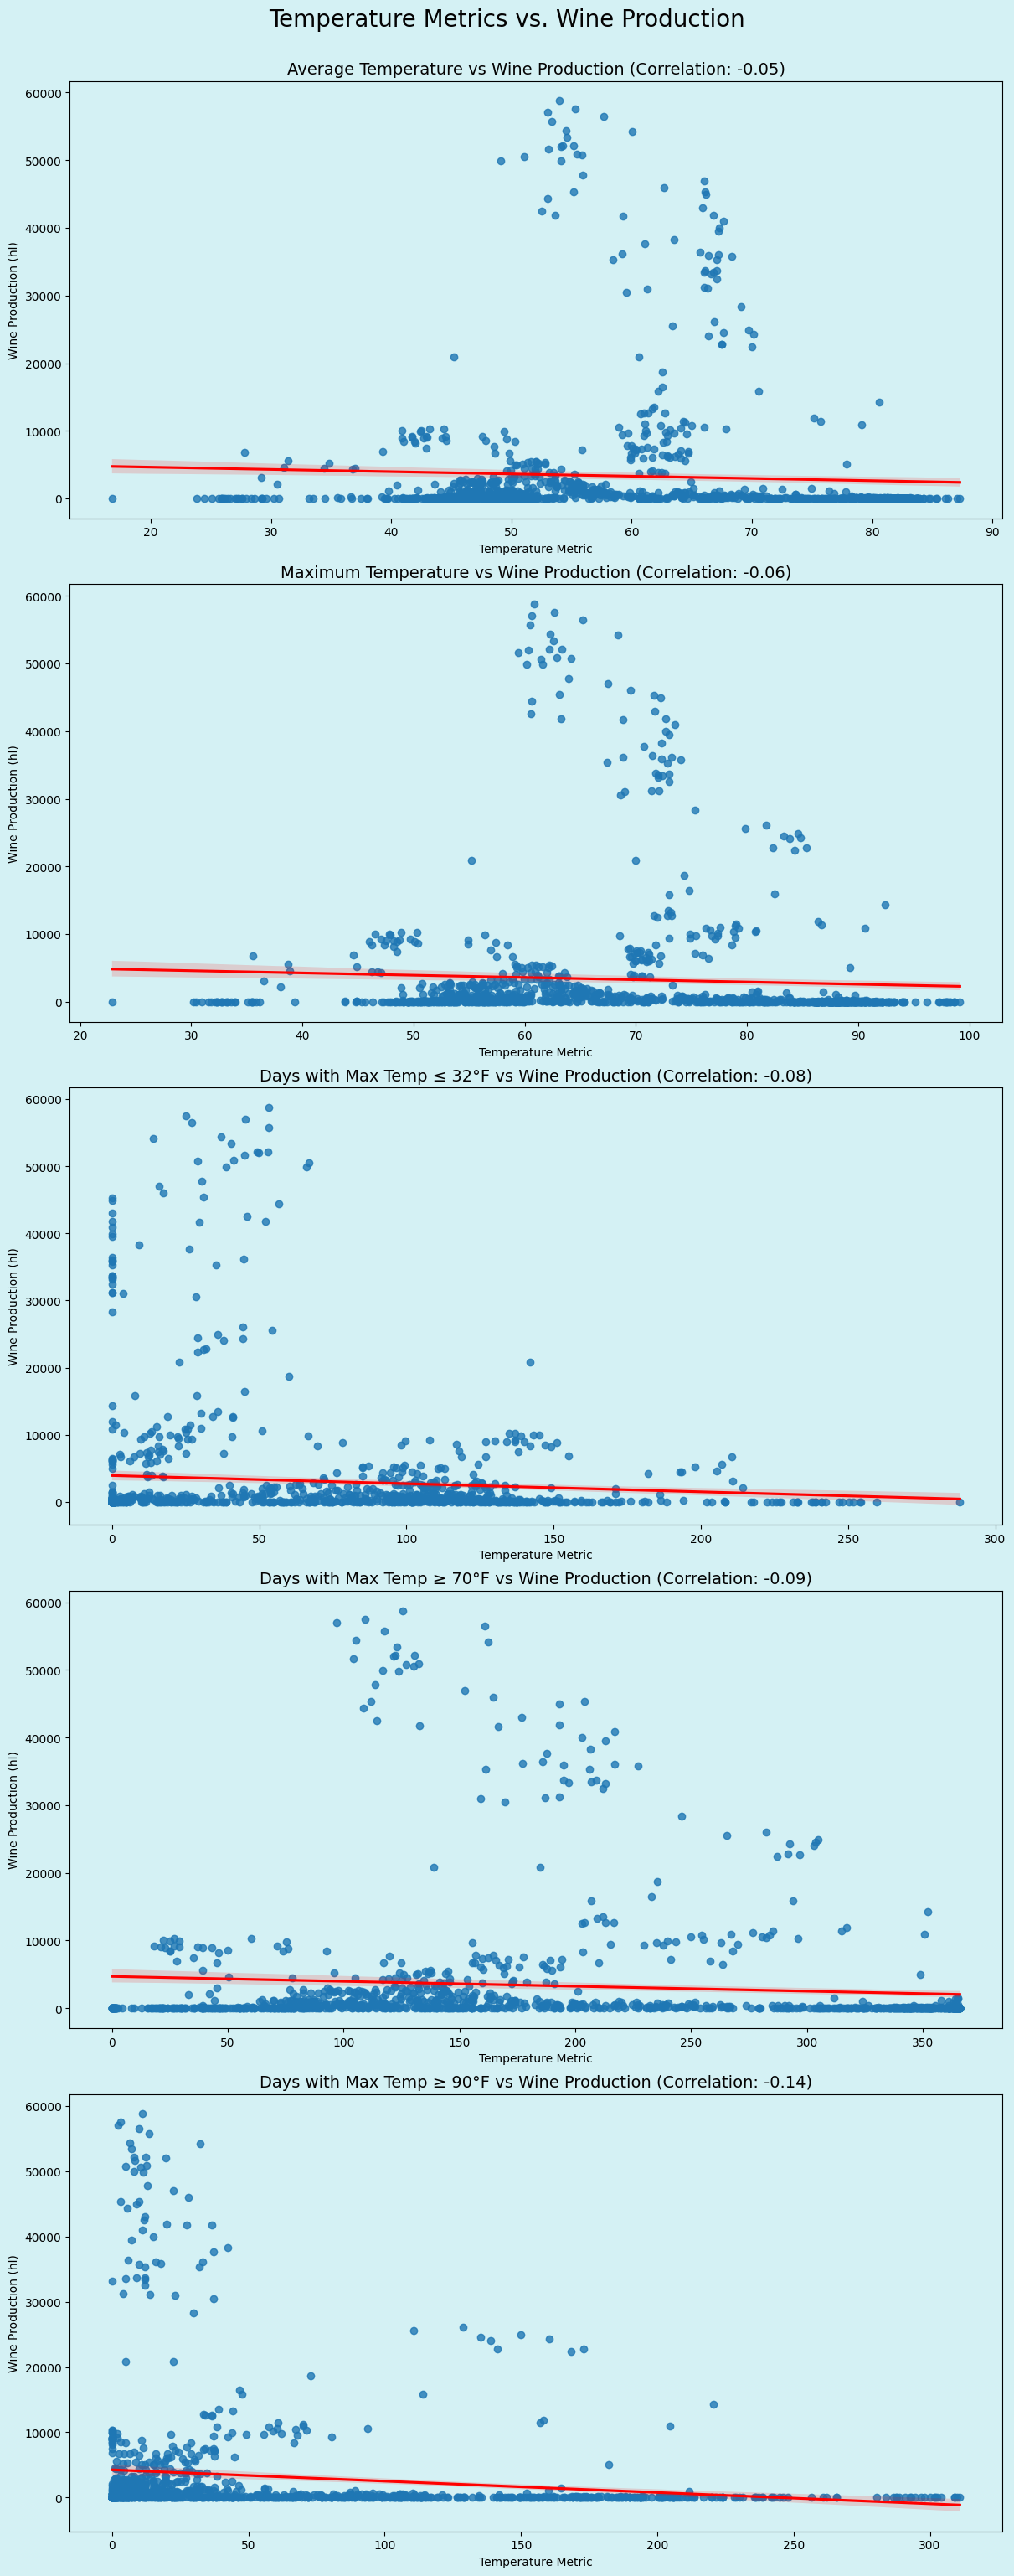

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data file
wine_weather_path = 'Outputs/merged_wine_weather_for_regions_data.csv'

wine_weather_df = pd.read_csv(wine_weather_path)

# Selecting relevant columns for correlation analysis
relevant_columns = ['Quantity_hl', 'tavg_mean', 'tmax_mean', 'dt32_mean', 'dx70_mean', 'dx90_mean']
wine_weather_subset = wine_weather_df[relevant_columns]

# Dropping rows with NaN values to ensure proper correlation calculation
wine_weather_subset = wine_weather_subset.dropna()

# Calculating the correlation matrix
correlation_matrix = wine_weather_subset.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Function to plot each metric with regression line and correlation coefficient
def plot_metric(ax, x, y, data, title):
    sns.regplot(ax=ax, x=x, y=y, data=data, line_kws={"color": "red"})
    corr = data[[x, y]].corr().iloc[0, 1]
    ax.set_title(f'{title} (Correlation: {corr:.2f})', fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel('')

# Set up the figure
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(12, 30), constrained_layout=True)

# Plot each temperature metric against wine production
plot_metric(axes[0], 'tavg_mean', 'Quantity_hl', wine_weather_subset, 'Average Temperature vs Wine Production')
plot_metric(axes[1], 'tmax_mean', 'Quantity_hl', wine_weather_subset, 'Maximum Temperature vs Wine Production')
plot_metric(axes[2], 'dt32_mean', 'Quantity_hl', wine_weather_subset, 'Days with Max Temp ≤ 32°F vs Wine Production')
plot_metric(axes[3], 'dx70_mean', 'Quantity_hl', wine_weather_subset, 'Days with Max Temp ≥ 70°F vs Wine Production')
plot_metric(axes[4], 'dx90_mean', 'Quantity_hl', wine_weather_subset, 'Days with Max Temp ≥ 90°F vs Wine Production')

# Add x and y labels
for ax in axes:
    ax.set_xlabel('Temperature Metric')
    ax.set_ylabel('Wine Production (hl)')

# Adjust layout
plt.suptitle('Temperature Metrics vs. Wine Production', y=1.02, fontsize=20)
plt.show()


/var/folders/_d/q6dl733j0hdfhxbg883rg3xc0000gn/T/ipykernel_44377/4091121629.py:25: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/_d/q6dl733j0hdfhxbg883rg3xc0000gn/T/ipykernel_44377/4091121629.py:25: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/_d/q6dl733j0hdfhxbg883rg3xc0000gn/T/ipykernel_44377/4091121629.py:25: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/_d/q6dl733j0hdfhxbg883rg

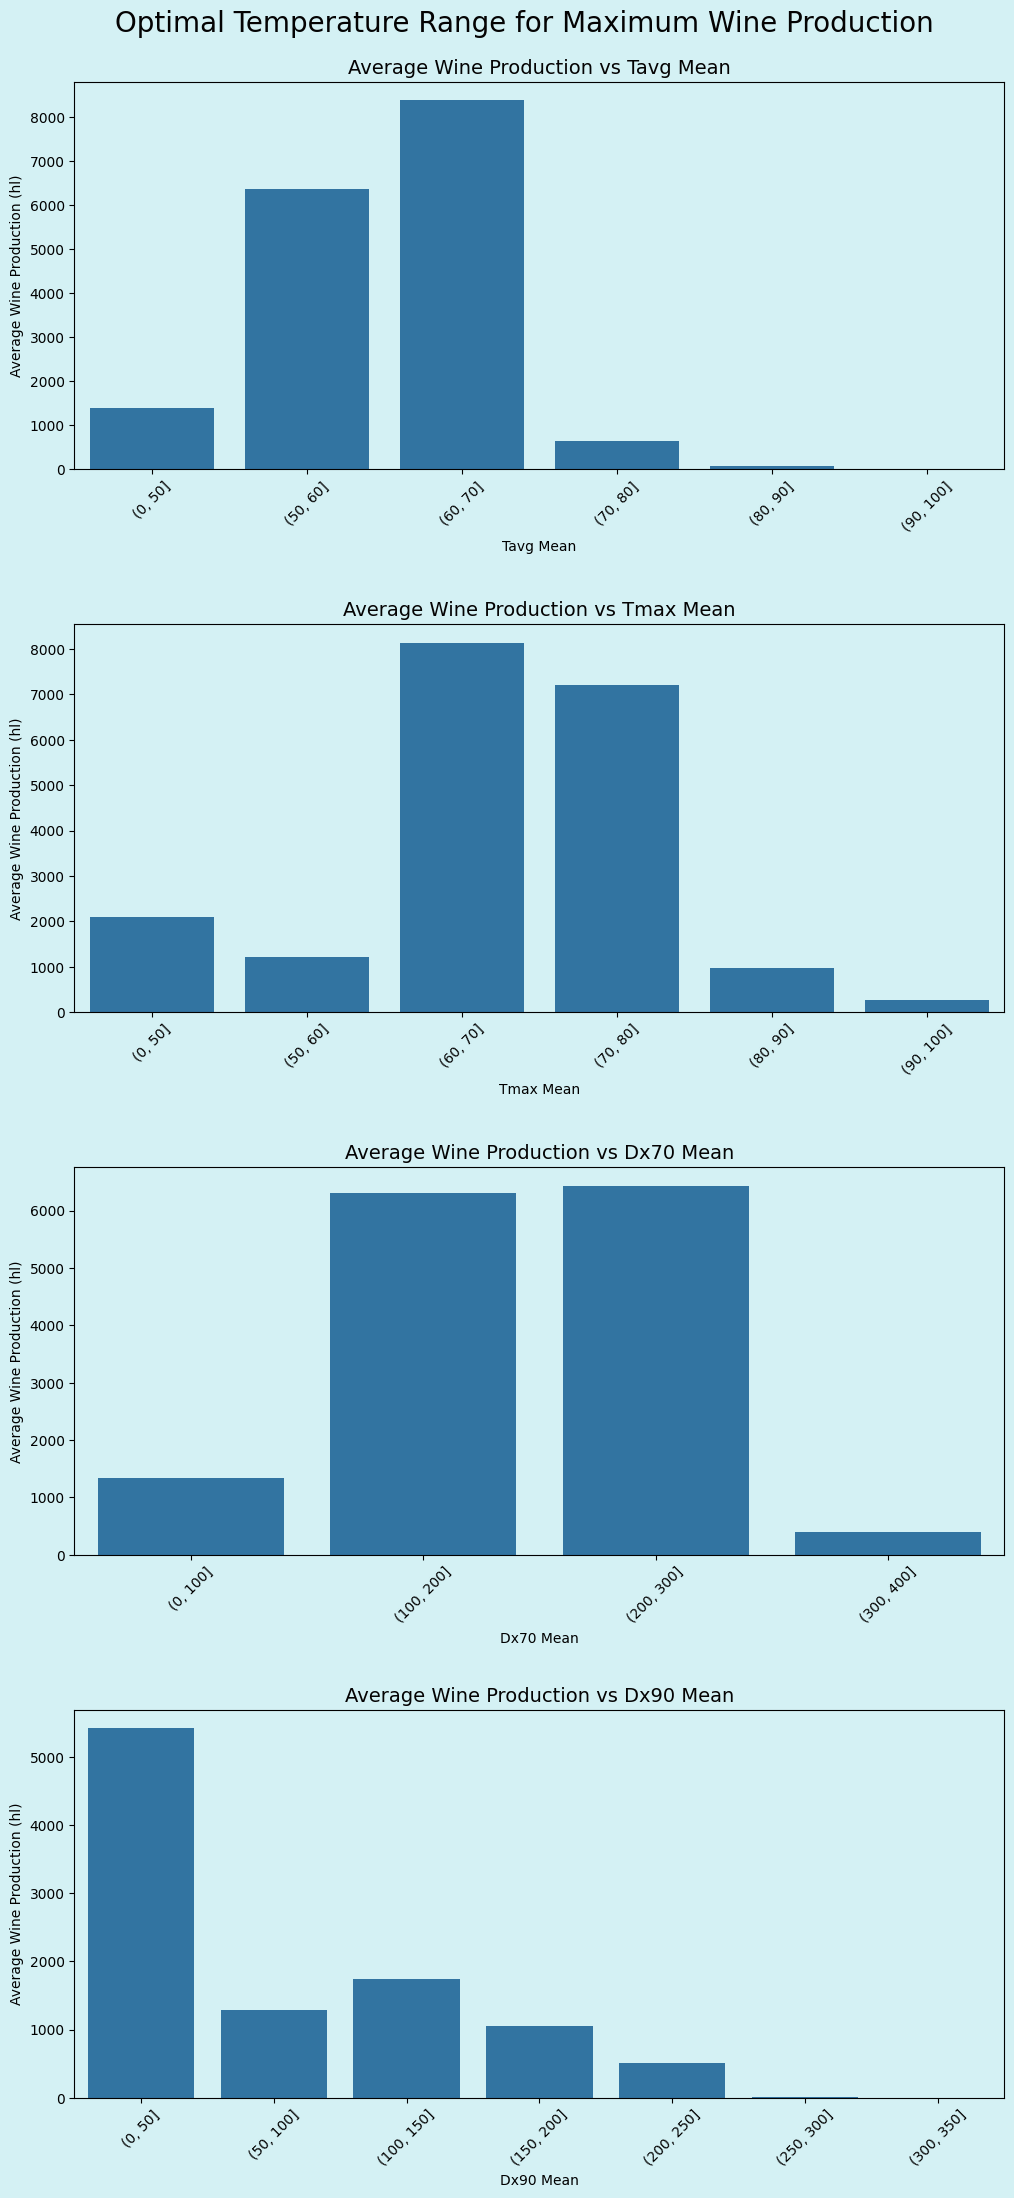

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Selecting relevant columns for analysis
relevant_columns = ['Quantity_hl', 'tavg_mean', 'tmax_mean', 'dx70_mean', 'dx90_mean']
wine_weather_subset = wine_weather_df[relevant_columns]

# Dropping rows with NaN values to ensure proper analysis
wine_weather_subset = wine_weather_subset.dropna()

# Segmenting data based on temperature ranges
temperature_bins = {
    'tavg_mean': [0, 50, 60, 70, 80, 90, 100],
    'tmax_mean': [0, 50, 60, 70, 80, 90, 100],
    'dx70_mean': [0, 100, 200, 300, 400],
    'dx90_mean': [0, 50, 100, 150, 200, 250, 300, 350]
}

# Calculate the average wine production for each temperature range
avg_production = {}

for temp_col, bins in temperature_bins.items():
    wine_weather_subset[f'{temp_col}_bin'] = pd.cut(wine_weather_subset[temp_col], bins=bins)
    avg_production[temp_col] = wine_weather_subset.groupby(f'{temp_col}_bin')['Quantity_hl'].mean().reset_index()

# Visualizing the results
fig, axes = plt.subplots(nrows=4, ncols=1, figsize=(12, 24))
fig.subplots_adjust(hspace=0.4, top=0.95)

for ax, (temp_col, avg_data) in zip(axes, avg_production.items()):
    sns.barplot(x=f'{temp_col}_bin', y='Quantity_hl', data=avg_data, ax=ax)
    ax.set_title(f'Average Wine Production vs {temp_col.replace("_", " ").title()}', fontsize=14)
    ax.set_xlabel(temp_col.replace("_", " ").title())
    ax.set_ylabel('Average Wine Production (hl)')
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Optimal Temperature Range for Maximum Wine Production', fontsize=20)
plt.show()



                            OLS Regression Results                            
Dep. Variable:            Quantity_hl   R-squared:                       0.055
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     17.26
Date:                Mon, 21 Oct 2024   Prob (F-statistic):           8.98e-14
Time:                        15:31:40   Log-Likelihood:                -12510.
No. Observations:                1188   AIC:                         2.503e+04
Df Residuals:                    1183   BIC:                         2.506e+04
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -1.768e+04   3282.909     -5.384      0.0

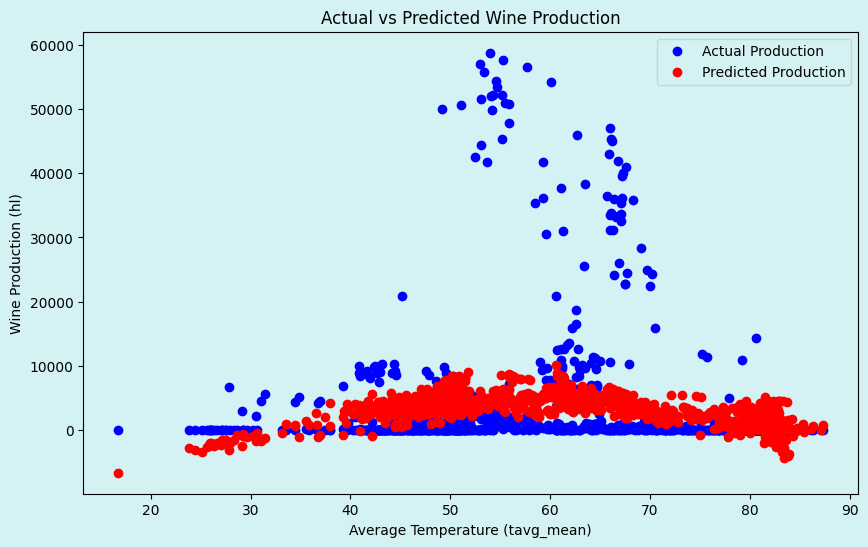

In [27]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Selecting relevant columns for analysis
relevant_columns = ['Quantity_hl', 'tavg_mean', 'tmax_mean', 'dx70_mean', 'dx90_mean']
wine_weather_subset = wine_weather_df[relevant_columns]

# Dropping rows with NaN values to ensure proper analysis
wine_weather_subset = wine_weather_subset.dropna()

# Define the independent variables (temperature metrics) and the dependent variable (wine production)
X = wine_weather_subset[['tavg_mean', 'tmax_mean', 'dx70_mean', 'dx90_mean']]
y = wine_weather_subset['Quantity_hl']

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Display the regression results
print(model.summary())

# Predict wine production using the model
wine_weather_subset['predicted_Quantity_hl'] = model.predict(X)

# Plot the actual vs predicted wine production
plt.figure(figsize=(10, 6))
plt.scatter(wine_weather_subset['tavg_mean'], wine_weather_subset['Quantity_hl'], color='blue', label='Actual Production')
plt.scatter(wine_weather_subset['tavg_mean'], wine_weather_subset['predicted_Quantity_hl'], color='red', label='Predicted Production')
plt.xlabel('Average Temperature (tavg_mean)')
plt.ylabel('Wine Production (hl)')
plt.title('Actual vs Predicted Wine Production')
plt.legend()
plt.show()


**Results**  
Correlations:  
First we looked at plots depicting the relationships between the different temperature variables and production.  From the correlation results, we can see that there is no clear trend for average temperature, where maximum temperature show minimal impact on productions. THe number of days metrics all show negative trends, indication that more days under 32 degrees, freezing, and the more days over 70 degrees, have slight trends. Where the number of days over 90 degrees has a stronger negative impact.  
When we look at the bar charts, 
  
Bar charts:  
From these charts we can see that average temps between 60-70 are best for production, with max temps over 80 are where prodcutions appears to drop. 100-300 days greater than 70 degrees are best for production values. And days with temperatures over 90, need to be limited to 50 in order to not impact production values.  
  
Regression Analysis:  
The R-squared value of 0.055 is a small number, indicating that little about these temperature values explains the changes seen in the model.  
The F-statistic of 17.26 is fairly high, indicating that the variance explained by the model is significantly greater than unexplained variance.  The extremely low p-value of 8.98e-14, much lower than the the cutoff of 0.05, meaning we can reject the null hypothesis, and conclude that at least one of the temperature variables contributes in a significant way to explaining the variability in wine production.

# 6. What is the optimal precipitation level for maximum wine production?

Correlation Matrix:
            Gallons  dp10_mean  dp1x_mean  prcp_mean
Gallons    1.000000  -0.156479  -0.155540  -0.162205
dp10_mean -0.156479   1.000000   0.804268   0.851176
dp1x_mean -0.155540   0.804268   1.000000   0.953963
prcp_mean -0.162205   0.851176   0.953963   1.000000


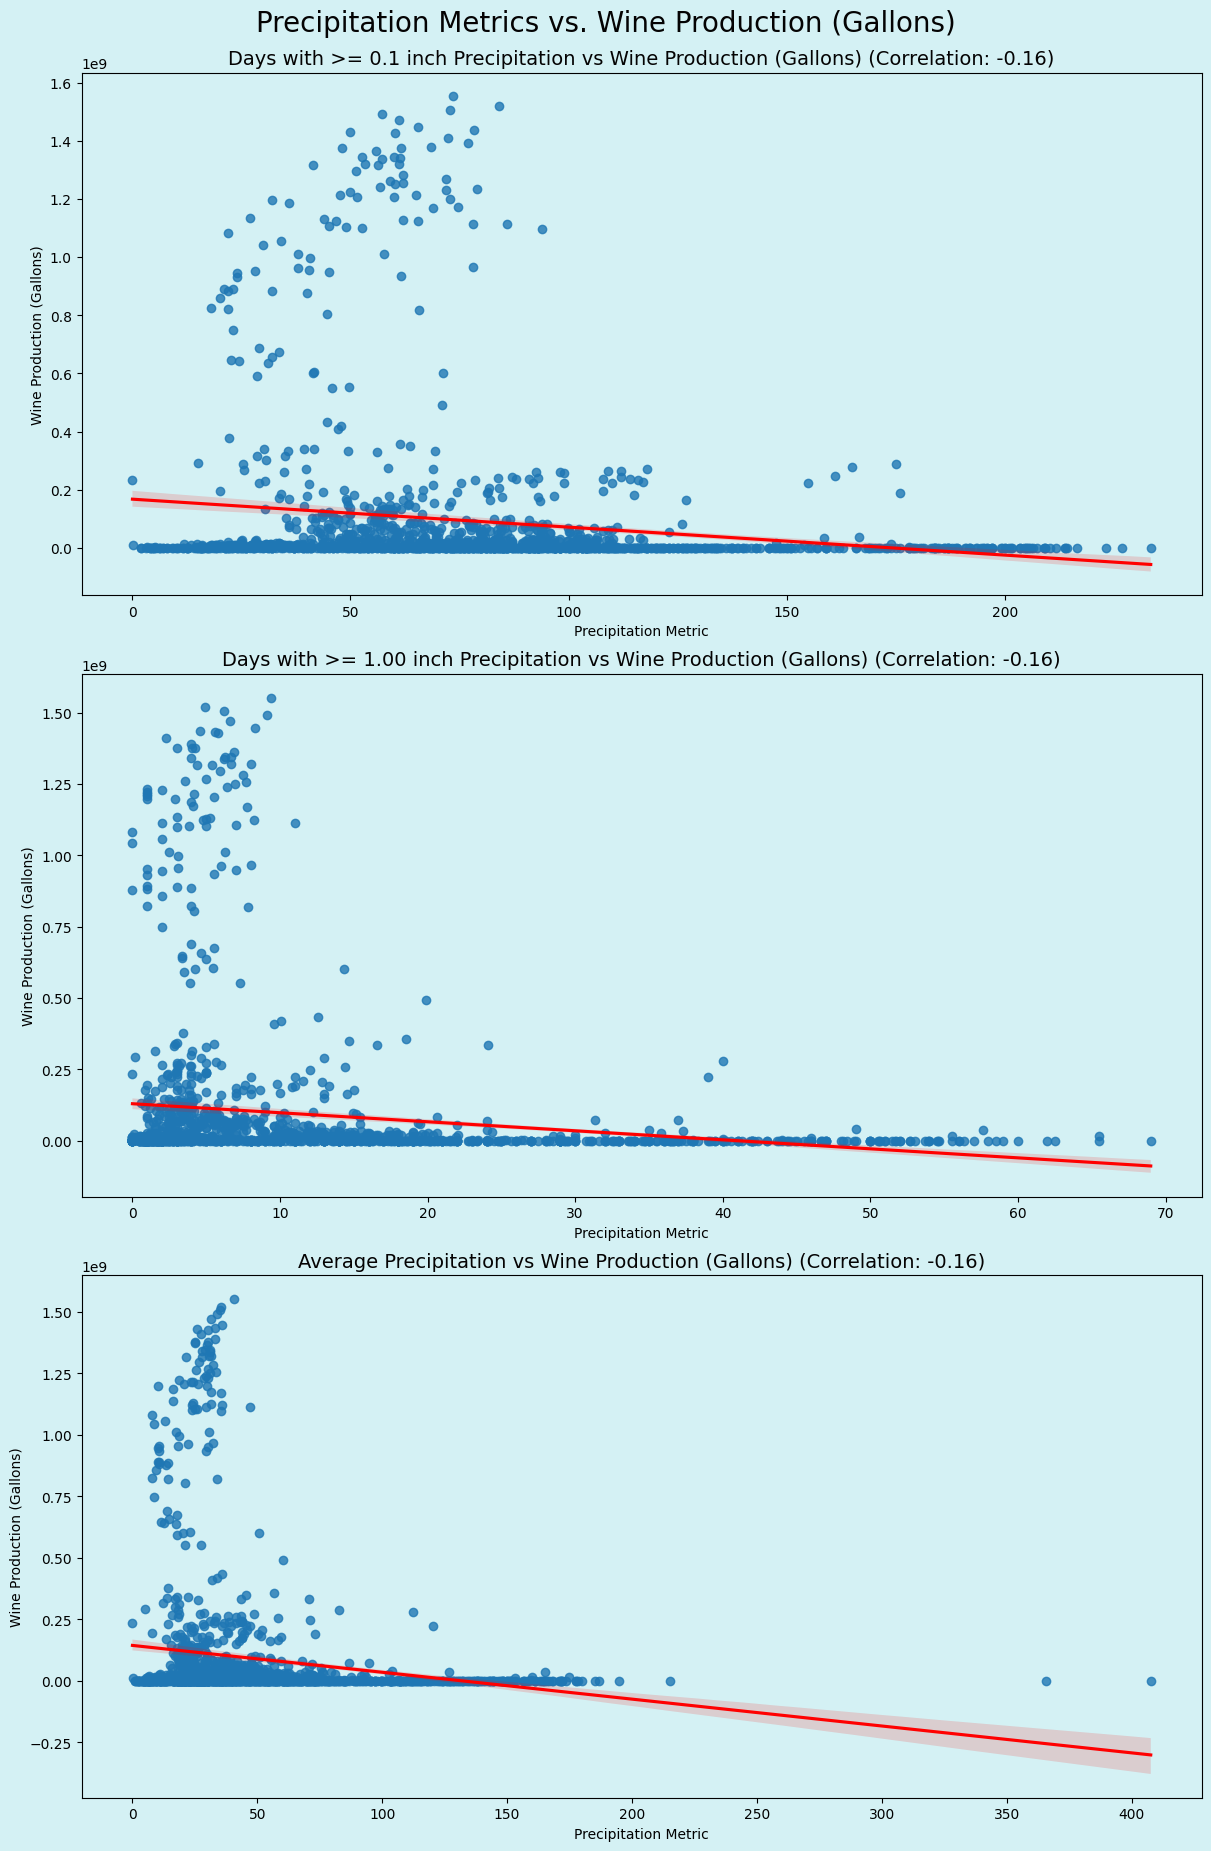

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data files
wine_weather_path = 'Outputs/merged_wine_weather_for_regions_data.csv'

wine_weather_df = pd.read_csv(wine_weather_path)

# Selecting relevant columns for correlation analysis
relevant_columns = ['Gallons', 'dp10_mean', 'dp1x_mean', 'prcp_mean']
wine_weather_subset = wine_weather_df[relevant_columns]

# Dropping rows with NaN values to ensure proper correlation calculation
wine_weather_subset = wine_weather_subset.dropna()

# Calculating the correlation matrix
correlation_matrix = wine_weather_subset.corr()

# Display the correlation matrix
print("Correlation Matrix:")
print(correlation_matrix)

# Function to plot each metric with regression line and correlation coefficient
def plot_metric(ax, x, y, data, title):
    sns.regplot(ax=ax, x=x, y=y, data=data, line_kws={"color": "red"})
    corr = data[[x, y]].corr().iloc[0, 1]
    ax.set_title(f'{title} (Correlation: {corr:.2f})', fontsize=14)
    ax.set_xlabel('')
    ax.set_ylabel('')

# Set up the figure
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18), constrained_layout=True)

# Plot each precipitation metric against wine production
plot_metric(axes[0], 'dp10_mean', 'Gallons', wine_weather_subset, 'Days with >= 0.1 inch Precipitation vs Wine Production (Gallons)')
plot_metric(axes[1], 'dp1x_mean', 'Gallons', wine_weather_subset, 'Days with >= 1.00 inch Precipitation vs Wine Production (Gallons)')
plot_metric(axes[2], 'prcp_mean', 'Gallons', wine_weather_subset, 'Average Precipitation vs Wine Production (Gallons)')

# Add x and y labels
for ax in axes:
    ax.set_xlabel('Precipitation Metric')
    ax.set_ylabel('Wine Production (Gallons)')

# Adjust layout
plt.suptitle('Precipitation Metrics vs. Wine Production (Gallons)', y=1.02, fontsize=20)
plt.show()



/var/folders/_d/q6dl733j0hdfhxbg883rg3xc0000gn/T/ipykernel_44377/2626316271.py:29: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/_d/q6dl733j0hdfhxbg883rg3xc0000gn/T/ipykernel_44377/2626316271.py:29: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.

/var/folders/_d/q6dl733j0hdfhxbg883rg3xc0000gn/T/ipykernel_44377/2626316271.py:29: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



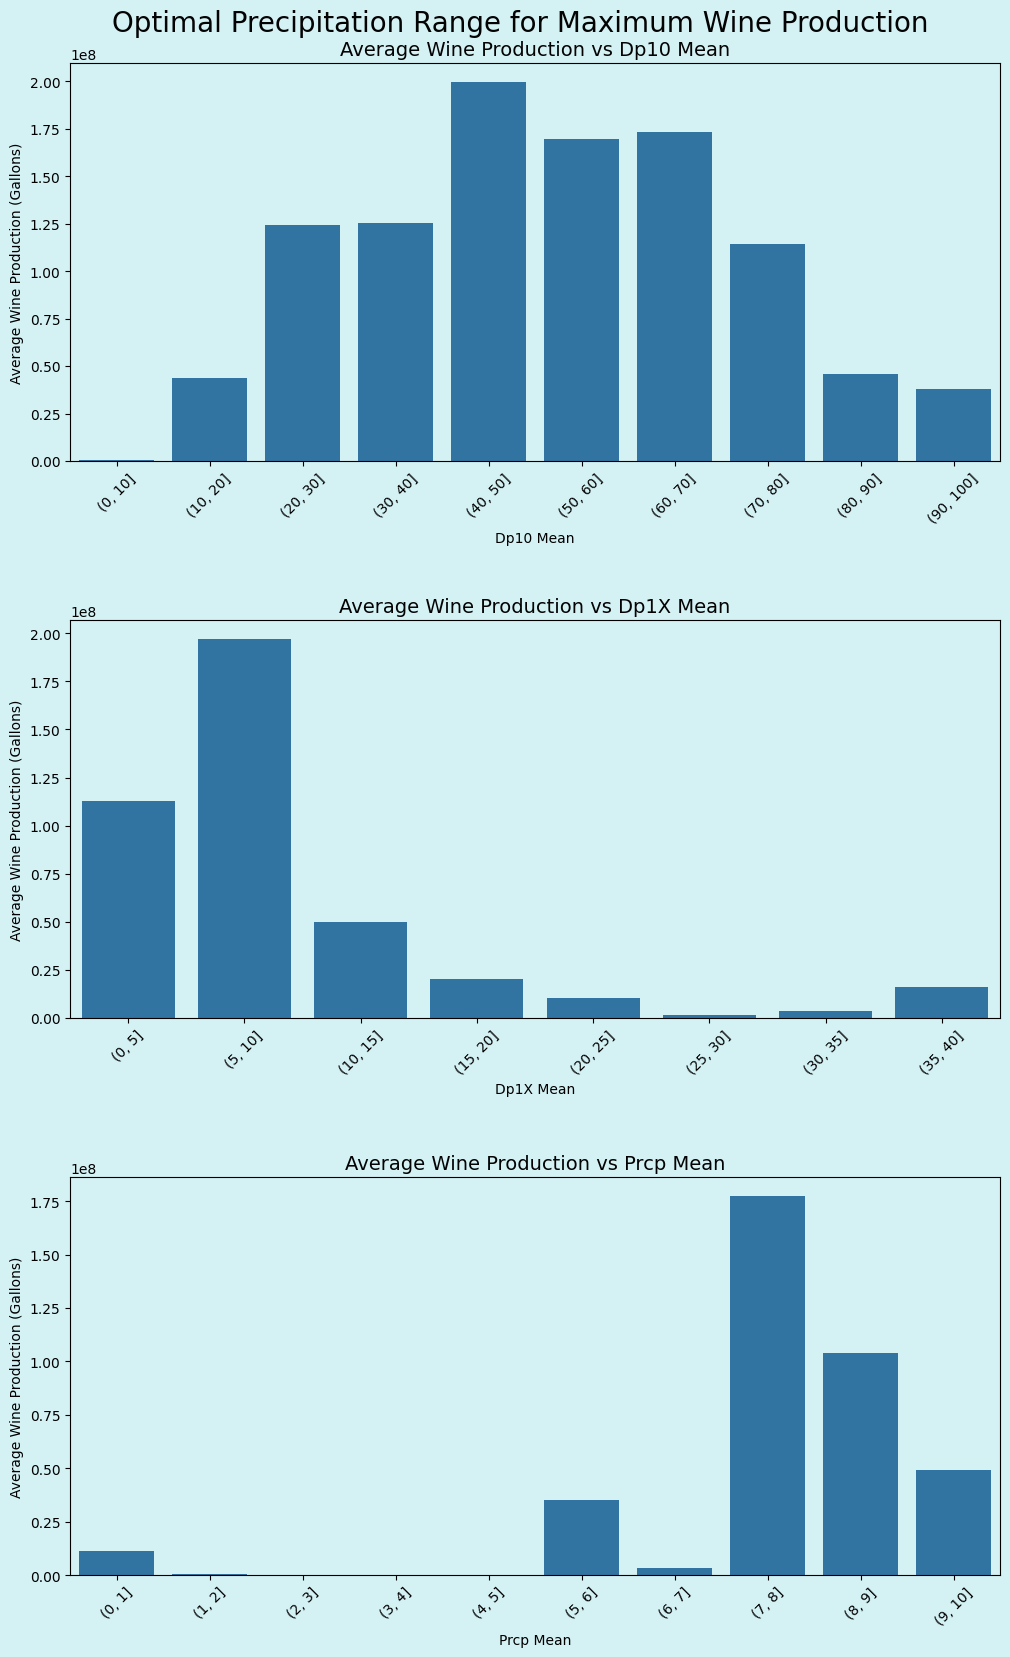

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the data file
wine_weather_path = 'Outputs/merged_wine_weather_for_regions_data.csv'

wine_weather_df = pd.read_csv(wine_weather_path)

# Selecting relevant columns for analysis
relevant_columns = ['Gallons', 'dp10_mean', 'dp1x_mean', 'prcp_mean']
wine_weather_subset = wine_weather_df[relevant_columns]

# Dropping rows with NaN values to ensure proper analysis
wine_weather_subset = wine_weather_subset.dropna()

# Segmenting data based on precipitation ranges
precipitation_bins = {
    'dp10_mean': [0, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
    'dp1x_mean': [0, 5, 10, 15, 20, 25, 30, 35, 40],
    'prcp_mean': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]
}

# Calculate the average wine production for each precipitation range
avg_production = {}

for precip_col, bins in precipitation_bins.items():
    wine_weather_subset[f'{precip_col}_bin'] = pd.cut(wine_weather_subset[precip_col], bins=bins)
    avg_production[precip_col] = wine_weather_subset.groupby(f'{precip_col}_bin')['Gallons'].mean().reset_index()

# Visualizing the results
fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(12, 18))
fig.subplots_adjust(hspace=0.4, top=0.95)

for ax, (precip_col, avg_data) in zip(axes, avg_production.items()):
    sns.barplot(x=f'{precip_col}_bin', y='Gallons', data=avg_data, ax=ax)
    ax.set_title(f'Average Wine Production vs {precip_col.replace("_", " ").title()}', fontsize=14)
    ax.set_xlabel(precip_col.replace("_", " ").title())
    ax.set_ylabel('Average Wine Production (Gallons)')
    ax.tick_params(axis='x', rotation=45)

plt.suptitle('Optimal Precipitation Range for Maximum Wine Production', fontsize=20)
plt.show()


                            OLS Regression Results                            
Dep. Variable:                Gallons   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.026
Method:                 Least Squares   F-statistic:                     14.09
Date:                Mon, 21 Oct 2024   Prob (F-statistic):           4.68e-09
Time:                        15:31:42   Log-Likelihood:                -31115.
No. Observations:                1495   AIC:                         6.224e+04
Df Residuals:                    1491   BIC:                         6.226e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       1.573e+08   1.56e+07     10.089      0.0

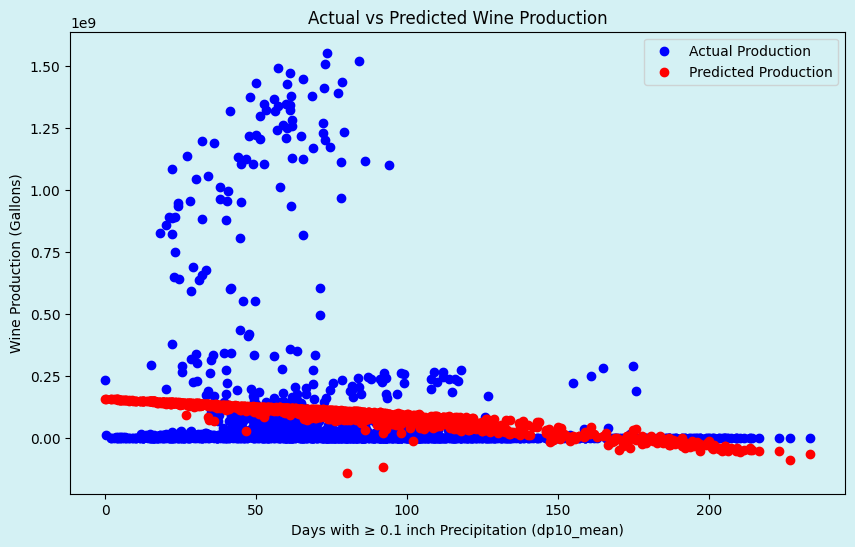

In [30]:
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load the data file
wine_weather_path = 'Outputs/merged_wine_weather_for_regions_data.csv'

wine_weather_df = pd.read_csv(wine_weather_path)

# Selecting relevant columns for analysis
relevant_columns = ['Gallons', 'dp10_mean', 'dp1x_mean', 'prcp_mean']
wine_weather_subset = wine_weather_df[relevant_columns]

# Dropping rows with NaN values to ensure proper analysis
wine_weather_subset = wine_weather_subset.dropna()

# Define the independent variables (precipitation metrics) and the dependent variable (wine production)
X = wine_weather_subset[['dp10_mean', 'dp1x_mean', 'prcp_mean']]
y = wine_weather_subset['Gallons']

# Add a constant to the independent variables
X = sm.add_constant(X)

# Fit the regression model
model = sm.OLS(y, X).fit()

# Display the regression results
print(model.summary())

# Predict wine production using the model
wine_weather_subset['predicted_Gallons'] = model.predict(X)

# Plot the actual vs predicted wine production
plt.figure(figsize=(10, 6))
plt.scatter(wine_weather_subset['dp10_mean'], wine_weather_subset['Gallons'], color='blue', label='Actual Production')
plt.scatter(wine_weather_subset['dp10_mean'], wine_weather_subset['predicted_Gallons'], color='red', label='Predicted Production')
plt.xlabel('Days with ≥ 0.1 inch Precipitation (dp10_mean)')
plt.ylabel('Wine Production (Gallons)')
plt.title('Actual vs Predicted Wine Production')
plt.legend()
plt.show()


**Results**  
Correlations:  
First we looked at plots depicting the relationships between the different precipitation variables and production. Of the three what were chosen was, average precipitation, days with more than an inch of rainfall, and days with greater than 0.1 inches of rainfall. 
  
Bar charts:  
From these charts we can see that days with more than an inch of rainfall is best for production if kept to 40-50 days.  Where only 5-10 days with greater than 0.1 inch is best.  
  
Regression Analysis:  
The R-squared value of 0.028 is a small number, indicating that little about these rainfall values explains the changes seen in the model.  
The F-statistic of 14.00 is fairly high, indicating that the variance explained by the model is significantly greater than unexplained variance.  The extremely low p-value of 4.68e-09, much lower than the the cutoff of 0.05, meaning we can reject the null hypothesis, and conclude that at least one of the precipitation variables contributes in a significant way to explaining the variability in wine production.

# Can we determine if climate had a postive or negative impact on production for any countries?

In [31]:
import pandas as pd

# Load the datasets
data_file_path = 'Outputs/merged_wine_weather_for_regions_data.csv'
glossary_file_path = 'Resources/DataType_Glossary.csv'

# Load data
data_df = pd.read_csv(data_file_path)
glossary_df = pd.read_csv(glossary_file_path)

# Filter the dataset to include only rows where 'Gallons' is greater than zero
non_zero_gallons_df = data_df[data_df['Gallons'] > 0]

# Filtered climate variables with sufficient data
sufficient_data_climate_vars = ['tmax_mean', 'prcp_mean', 'tmax_std', 'tavg_mean', 'prcp_std', 'tavg_std']

# Function to calculate correlation for each country
def calculate_country_correlations_v2(df, climate_vars):
    country_correlations = {}
    for country in df['country'].unique():
        country_data = df[df['country'] == country]
        if country_data.shape[0] > 1:  # Ensure there is more than one data point
            correlations = country_data[['Gallons'] + climate_vars].corr()['Gallons']
            country_correlations[country] = correlations.drop('Gallons')
    return country_correlations

# Calculate correlations using the filtered dataset
country_correlations_filtered_v2 = calculate_country_correlations_v2(non_zero_gallons_df, sufficient_data_climate_vars)

# Convert the correlation results into a DataFrame for easier analysis
correlation_df_filtered_v2 = pd.DataFrame(country_correlations_filtered_v2).T

# Identify the top 5 countries with the highest and lowest average correlation with climate variables
correlation_df_filtered_v2['average_correlation'] = correlation_df_filtered_v2.mean(axis=1)
top_5_benefit_filtered_v2 = correlation_df_filtered_v2['average_correlation'].nlargest(5)
bottom_5_benefit_filtered_v2 = correlation_df_filtered_v2['average_correlation'].nsmallest(5)

# Display the results
print("Top 5 countries benefiting the most from climate variables:")
print(top_5_benefit_filtered_v2)

print("\nTop 5 countries benefiting the least from climate variables:")
print(bottom_5_benefit_filtered_v2)


Top 5 countries benefiting the most from climate variables:
Paraguay      0.683194
Azerbaijan    0.576667
Tunisia       0.382831
Malta         0.375448
Peru          0.315708
Name: average_correlation, dtype: float64

Top 5 countries benefiting the least from climate variables:
Moldova   -0.827045
Egypt     -0.434459
Chile     -0.429056
Romania   -0.402318
Brazil    -0.365009
Name: average_correlation, dtype: float64


**Correlation Analysis**  
Using correlation analysis, we were able to determine the top and bottom countries that were most affected by climate changes